# Handwriting Synthesis
This notebook is a personal attempt at coding Alex Graves RNN to predict handwriting (section 5). The paper can be found [here](https://arxiv.org/abs/1308.0850). It is almost the same as the handwriting prediction network (Handwriting prediction - Model 2) but incorporates an attention mechanism so the network learns what character it is writing.

The goal of this notebook is to implement a network in a straightforward manner. As such, code readability is a priority over performance. The implemented network consists of layers of LSTM followed by a Gaussian mixtures layer, with an attention mechanism in between. Handwriting is highly variable. It makes more sense to generate a probability density function at each time step for the next stroke to capture that essence.

The network is tweakable in sequence length, number of mixtures and dropout probability.

The notebook is divided into data treatment (I used [Greydanus's code](https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb) for that as that part is boring, a variation from hardmaru's code) some useful functions, network class, loss function and training. 

The dataset comes from [IAM On-Line Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database). Download data/lineStrokes-all.tar.gz after signing up ! The path should be ./data/lineStrokes if you want to use this notebook.

Enjoy :)

In [1]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import svgwrite
from IPython.display import SVG, display
import matplotlib.cm as cm

import torch
from torch import nn, optim
import torch.nn.functional as F
use_cuda = False
use_cuda = torch.cuda.is_available()

import time
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress

n_batch = 20
sequence_length = 400
U_items = int(sequence_length/25)

hidden_size = 256
n_layers = 3
n_gaussians = 20
Kmixtures = 10

eps = float(np.finfo(np.float32).eps)

# Hyperparameters
gradient_threshold = 10
dropout = 0.2



torch.cuda.empty_cache()

## Dataloader
This code comes from [Greydanus](https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb). Big thanks to his author !

That part is not that fun. Dataloader is a class that parses all the .xml files. It creates a pickle file for future use. It creates a training set containing sequences x, y (same as x but shifted one timestep) and c (one-hot encoding of the sequence) in batches depending on the sequence length. Function `next_batch()` neatly returns a batch. Use `reset_batch_pointer()` to reset the current batch. See the training function for a proper use of that wonderful code. 

In this notebook, we won't use the hot-one vectors as it is used to implement the attention mechanism of section 5 of the paper.

Some examples of training data :

![batch2](./pictures/batch_model2.png)

And some example code to load the data :

```python
x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
```

In [2]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))

        
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data_generation.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print ("creating training data cpkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print ("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print ("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print ("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print ("Loaded dataset:")
        print ("   -> {} individual data points".format(len(self.stroke_data)))
        print ("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print ("pointer reset")

# Utils

Here are a couple of useful functions

`line_plot(strokes, title)`: plots a sequence. Results look like this :

![batch2](./pictures/batch_model2.png)

`one_hot(s)`: transforms a string sequence into a one-hot matrix. Dimensions of the output one-hot matrix are (string length, len(alphabet)). For example :

```python
s = "writing is hard"
print(one_hot(s))
```

`plot_heatmaps(Phis, Ws)`: plots Phis and soft-window heatmaps. It corresponds to the values of equations 46 and 47 of the paper. 

![heatmpas](./pictures/heatmaps.png)
![heatmpas](./pictures/eq46-47.png)

`def get_n_params(model)`: returns the number of parameters of a model

And some example code to load the data :

```python
x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
```



In [3]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def one_hot(s):
    #index position 0 means "unknown"
    alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
    seq = [alphabet.find(char) + 1 for char in s]

    one_hot = np.zeros((len(s),len(alphabet)+1))
    one_hot[np.arange(len(s)),seq] = 1
    return one_hot

def plot_heatmaps(Phis, Ws):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Phis', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("ascii #", fontsize=15)
    
    plt.imshow(Phis, interpolation='nearest', aspect='auto', cmap=cm.jet)
    plt.subplot(122)
    plt.title('Soft attention window', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("one-hot vector", fontsize=15)
    plt.imshow(Ws, interpolation='nearest', aspect='auto', cmap=cm.jet)

    display(plt.gcf())
    

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp





## Model

This is where the fun begins. The network consists of LSTM cells stacked on top of each other and followed by a Gaussian mixture layer with an attention mechanism in between. This network includes skip connections like the paper. It is almost the same network as the one in my other notebook (Handwriting prediction - Model 2) but with the attention mechanism.


`__init__(self, hidden_size = 256, n_gaussians = 10, Kmixtures = 10, dropout = 0.2, alphabet_size = 64)` :
This is the constructor. It takes the different parameters to create the different blocks of the model.
- hidden_size is the size of the output of each LSTM cell
- n_gaussians is the number of mixtures
- Kmixtures is the number of Gaussian functions for the window vectors
- dropout is the dropout probability. It gives the probability to skip a cell during forward propagation. It's not implemented actually
- alphabet_size is the number of characters in our dictionary

The attention mechanisme is implemented between LSTM1 and LSTM2. LSTM1 takes as inputs the window vectors of the previous time step as well as current stroke coordinates. A dense layer is used taking the output of LSTM1 to compute the parameters of the window vectors. The current window vector is passed on to LSTM2 and LSTM3 as well as the stroke coordinates via skip connections. LSTM2 and LSTM3 of course take the hidden vectors of the LSTM1 and LSTM2 respectively. This is summarized by equations 52 and 53.

![eq52-53](./pictures/eq52-53.png)

The Gaussian mixtures are created using a dense layer. It takes the output of the last LSTM layer. Say the hidden size is 256 and you want 10 mixtures, this allows to scale your vector to the desired size. This gives ŷ of equation 17 of the paper.

![eq17](./pictures/eq17.png)

ŷ is then broken down into the different parameters of the mixture. 
- ê is the probability of the end of a stroke given by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)
- w (or $\Pi$ ) is the weight of each Normal distribution
- $\mu, \sigma, \rho$ are the mean, standard deviation and correlation factor of each [bivariate Normal Distribution](http://mathworld.wolfram.com/BivariateNormalDistribution.html)
The constructor juste lays out the blocks but does not create relations between them. That's the job of the forward function.

The network is summarized by figure 12 (it does show the third hidden layer which does pretty much the same thing as the second).

![figure12](./pictures/figure12.png)



`forward(self, x, c)` :
This is the forward propagation. It takes x and c as inputs. 

x is a batch of stroke coordinates of sequences. Its dimensions are [sequence_size, batch_size, 3]. The 3 corresponds to x and y offset of a stroke and eos (= 1 when reaching an end of stroke (when the pen is raised)). 

c, a batch of one-hot encoded sentences corresponding to the stroke sequence is of dimensions [n_batch, U_items, len(alphabet)]. It is estimated that a letter corresponds to 25 points. U_items is the number of characters in the sequence. For example, if the sequence is 400 points long, U_items = 400 / 25 = 16 charcaters. len(alphabet) is the number of characters in our alphabet.

Note that the forward function is also used to generate random sequences.

The first step is to compute LSTM1. This is straightfoward in PyTorch. Since I created LSTM cells in Pytorch. I need a for loop over the whole stroke sequence.

After LSTM1, the code computes the attention mechanism given by equations 46-51 of the paper.

![eq46-47](./pictures/eq46-47.png)
![eq48-51](./pictures/eq48-51.png)

After that, the networks computes LSTM2 and LSTM3. Then it's just a matter of computing 18 - 22 of the paper using a dense layer.
![eq18-22](./pictures/eq18-22.png)




`generate_sequence(self, x0, c0)` :
This is where I clearly sacrifice performance for readability. The goal of this function is to return a sequence based on either a single point or begining of sequence x0. In pseudo-code :
- Calculte the mixture parameters of sequence x0 given one-hot encoded string c0
- Pick a random mixture based on the weights (pi_idx)
- Take a random point from the chosen bivariate normal distribution
- Add it at the end of the sequence (concatenate it)
- Repeat


This clearly is bad practise as I have to rerun the forward prop on the entire sequence each time. And the sequence gets longer and longer which takes more time to compute at each new point generated. However this holds in just a few lines and keeps the forward function cleaner.


`generate_sample(self, mu1, mu2, sigma1, sigma2, rho)` :
Returns random coordinates based on a bivariate normal distribution given by the function parameters. 


In [4]:
class HandwritingSynthesisModel(nn.Module):
    def __init__(self, hidden_size = 256, n_gaussians = 20, Kmixtures = 10, dropout = 0.2, alphabet_size = 64):
        super(HandwritingSynthesisModel, self).__init__()
        
        self.Kmixtures = Kmixtures
        self.n_gaussians = n_gaussians
        self.alphabet_size = alphabet_size
        
        self.hidden_size1 = hidden_size
        self.hidden_size2 = hidden_size
        self.hidden_size3 = hidden_size
        
        # input_size1 includes x, y, eos and len(w_t_1) given by alphabet_size (see eq 52)
        self.input_size1 = 3 + alphabet_size
        
        # input_size2 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size1
        self.input_size2 = 3 + alphabet_size + self.hidden_size1
        
        # input_size3 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size2
        self.input_size3 = 3 + alphabet_size + self.hidden_size2
        
        # See eq 52-53 to understand the input_sizes
        self.lstm1 = nn.LSTMCell(input_size= self.input_size1 , hidden_size = self.hidden_size1)
        self.lstm2 = nn.LSTMCell(input_size= self.input_size2 , hidden_size = self.hidden_size2)
        self.lstm3 = nn.LSTMCell(input_size= self.input_size3 , hidden_size = self.hidden_size3)
        
        # Initialize weights of LSTM cells
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.075)
        
        # Window layer takes hidden layer of LSTM1 as input and outputs 3 * Kmixtures vectors
        self.window_layer = nn.Linear(self.hidden_size1, 3 * Kmixtures)
        
        # Initialize weights of soft window dense layer
        for name, param in self.window_layer.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=-4, std=0.1)
            elif 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.075)
        
        # For gaussian mixtures
        self.z_e = nn.Linear(hidden_size, 1)
        self.z_pi = nn.Linear(hidden_size, n_gaussians)
        self.z_mu1 = nn.Linear(hidden_size, n_gaussians)
        self.z_mu2 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma1 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma2 = nn.Linear(hidden_size, n_gaussians)
        self.z_rho = nn.Linear(hidden_size, n_gaussians)
        
        
    def forward(self, x, c):
        # sequence length
        sequence_length = x.shape[0]
        
        # number of batches
        n_batch = x.shape[1]
        
        # Soft window vector w at t-1
        w_t_1 = torch.ones(n_batch, self.alphabet_size) # torch.Size([n_batch, len(alphabet)])
        
        # Hidden and cell state for LSTM1
        h1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        c1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        
        # Kappa at t-1
        kappa_t_1 = torch.zeros(n_batch, Kmixtures) # torch.Size([n_batch, Kmixtures])
        
        # Hidden and cell state for LSTM2
        h2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        c2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        
        # Hidden and cell state for LSTM3
        h3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        c3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        
        out = torch.zeros(sequence_length, n_batch, self.hidden_size3)
        
        # Phis and Ws allow to plot heatmaps of phi et w over time
        self.Phis = torch.zeros(sequence_length, U_items)
        self.Ws = torch.zeros(sequence_length, self.alphabet_size)
        
        if use_cuda:
            w_t_1 = w_t_1.cuda()
            
            h1_t = h1_t.cuda()
            c1_t = c1_t.cuda()
            
            kappa_t_1 = kappa_t_1.cuda()
            
            h2_t = h2_t.cuda()
            c2_t = c2_t.cuda()
            
            h3_t = h3_t.cuda()
            c3_t = c3_t.cuda()
            
            out = out.cuda()
            
        for i in range(sequence_length):
            # ===== Computing 1st layer =====
            input_lstm1 = torch.cat((x[i], w_t_1), 1) # torch.Size([n_batch, input_size1])
            h1_t, c1_t = self.lstm1(input_lstm1, (h1_t, c1_t)) # torch.Size([n_batch, hidden_size1])
            
            # ===== Computing soft window =====
            window = self.window_layer(h1_t)
            
            # splits exp(window) into 3 tensors of torch.Size([n_batch, Kmixtures])
            # Eqs 48-51 of the paper
            alpha_t, beta_t, kappa_t = torch.chunk( torch.exp(window), 3, dim=1) 
            kappa_t += kappa_t_1
            
            # updates kappa_t_1 for next iteration
            kappa_t_1 = kappa_t
            
            u = torch.arange(0,U_items, out=kappa_t.new()).view(-1,1,1) # torch.Size([U_items, 1, 1])
            
            # Computing Phi(t, u)
            # Eq 46 of the paper
            # Keep in mind the (kappa_t - u).shape is torch.Size([U_items, n_batch, Kmixtures])
            # For example :
            ## (kappa_t - u)[0, 0, :] gives kappa_t[0, :]
            ## (kappa_t - u)[1, 0, :] gives kappa_t[0, :] - 1
            ## etc
            Phi = alpha_t * torch.exp(- beta_t * (kappa_t - u) ** 2) # torch.Size([U_items, n_batch, Kmixtures])
            Phi = torch.sum(Phi, dim = 2) # torch.Size([U_items, n_batch])  
            Phi = torch.unsqueeze(Phi, 0) # torch.Size([1, U_items, n_batch])
            Phi = Phi.permute(2, 0, 1) # torch.Size([n_batch, 1, U_items])
            
            self.Phis[i, :] = Phi[0, 0, :] # To plot heatmaps
            
            # Computing wt 
            # Eq 47 of the paper
            w_t = torch.matmul(Phi, c) # torch.Size([n_batch, 1, len(alphabet)])
            w_t = torch.squeeze(w_t, 1) # torch.Size([n_batch, len(alphabet)])
            
            self.Ws[i, :] = w_t[0, :] # To plot heatmaps
            
            # Update w_t_1 for next iteration
            w_t_1 = w_t
            
            # ===== Computing 2nd layer =====
            input_lstm2 = torch.cat((x[i], w_t, h1_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size1])
            h2_t, c2_t = self.lstm2(input_lstm2, (h2_t, c2_t)) 
            
            
            # ===== Computing 3rd layer =====
            input_lstm3 = torch.cat((x[i], w_t, h2_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size2])
            h3_t, c3_t = self.lstm2(input_lstm2, (h3_t, c3_t))
            out[i, :, :] = h3_t
            
        # ===== Computing MDN =====
        es = self.z_e(out)
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
        # print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out)
        # print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
        # print(pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out)
        mu2s = self.z_mu2(out)
        # print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
        # print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s)
        sigma2s = torch.exp(sigma2s)
        # print(sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
        # print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2) 
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])


        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos
    
    
    
    
    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]
        
        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
        
        
    def generate_sequence(self, x0, c0):
        sequence = x0
        sequence_length = c0.shape[1] * 25
        
        print("Generating sequence ...")
        f = FloatProgress(min=0, max=sequence_length)
        display(f)

        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.forward(sequence, c0)
            
            # Selecting a mixture 
            pi_idx = np.random.choice(range(self.n_gaussians), p=pis[-1, 0, :].detach().cpu().numpy())
            
            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[-1, :, pi_idx].item()
            mu2 = mu2s[-1, :, pi_idx].item()
            sigma1 = sigma1s[-1, :, pi_idx].item()
            sigma2 = sigma2s[-1, :, pi_idx].item()
            rho = rhos[-1, :, pi_idx].item()
            
            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[-1, :].item()])).sample()
            
            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos
            
            sequence = torch.cat((sequence, sample), 0) # torch.Size([sequence_length, 1, 3])
            
            f.value += 1
        
        return sequence.squeeze(1).detach().cpu().numpy()


## Implementing density probability

It's time to implement the probability density of our next point given our output vector (the Gaussian mixtures parameters). In the paper, this is given by equations 23-25. This will be useful when computing the loss function. 

![eq23-25](./pictures/eq23-25.png)

I chose to exclude the Bernouilli part for now. It will be computed in the loss function.

`gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)` :

Remember the forward function of our model. gaussianMixture(...) takes for parameters its outputs. As such, it computes the results of equation 23 of the whole sequence over the different batches. A note on parameter y. It is basically the same tensor as x but shifted one time step. Think of it as $x_{t+1}$ in equation 23. It allows the last point of a sequence to still be learned correctly.


In [5]:
def gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
    n_mixtures = pis.size(2)
    
    # Takes x1 and repeats it over the number of gaussian mixtures
    x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0) 
    # print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # first term of Z (eq 25)
    x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
    # print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)  
    # print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # second term of Z (eq 25)
    x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
    # print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # third term of Z (eq 25)
    coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s) 
    
    # Computing Z (eq 25)
    Z = x1norm + x2norm - coxnorm
    
    # Gaussian bivariate (eq 24)
    N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5) 
    # print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians]) 
    
    # Pr is the result of eq 23 without the eos part
    Pr = pis * N 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])   
    Pr = torch.sum(Pr, dim=2) 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])   
    
    if use_cuda:
        Pr = Pr.cuda()
    
    return Pr

## Computing loss fn

The goal is to maximize the likelihood of our estimated bivariate normal distributions and Bernoulli distribution. Think about it this way. We generate parameters for our distributions but we want them to fit as best as possible to our data. Each training step's goal is to converge toward the best parameters for our data. [Click here to read more about likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).

In the paper, the loss is given by equation 26 :

![eq26](./pictures/eq26.png)

We previously calculated the first element of the equation in gaussianMixture(...). What's left is to add the Bernoulli loss (second part of our equation). The loss of each time step is summed up and averaged over the batches.



In [6]:
def loss_fn(Pr, y, es):
    loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])    
    bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])
    
    bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)
    
    loss2 = - torch.log(bernouilli + eps)
    loss = loss1 + loss2 
    # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])  
    loss = torch.sum(loss, 0) 
    # print("loss shape", loss.shape) # -> torch.Size([batch]) 
    
    return torch.mean(loss);
    
    

## Training

The hardest part is behind us ! All that's left is to train our model. I used an Adam optimizer with a learning rate of 0.005. I haven't fiddled around too much with it as it already yields good results with my other model (Handwriting prediction - Model 2). The gradients are clipped inside [-gradient_threshold, gradient_treshold] to avoid exploding gradient. 



In [7]:
def train_network(model, epochs = 5, generate = True):
    data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
    
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    # A sequence the model is going to try to write as it learns
    c0 = np.float32(one_hot("writing is hard!"))
    c0 = torch.from_numpy(c0) 
    c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))
    start = time.time()
    
    if use_cuda:
        model = model.cuda()
        c0 = c0.cuda()
        
    # Arrays to plot loss over time
    time_batch = []
    time_epoch = [0]
    loss_batch = []
    loss_epoch = []
    
    # Loop over epochs
    for epoch in range(epochs):
        data_loader.reset_batch_pointer()
        
        # Loop over batches
        for batch in range(data_loader.num_batches):
            # Loading a batch (x : stroke sequences, y : same as x but shifted 1 timestep, c : one-hot encoded character sequence ofx)
            x, y, s, c = data_loader.next_batch()
            x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
            y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
            c = np.float32(np.array(c))

            x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))
            
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
                c = c.cuda()
            
            # Forward pass
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x, c)
            
            # Calculate probability density and loss
            Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            loss = loss_fn(Pr,y, es)
            
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient cliping
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
            optimizer.step()
            
            # Useful infos over training
            if batch % 10 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", data_loader.num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                start = time.time()
                
                # Plot heatmaps every 100 batch
                if batch % 100 == 0:
                    print(s[0])
                    plot_heatmaps(model.Phis.transpose(0, 1).detach().numpy(), model.Ws.transpose(0, 1).detach().numpy())
                    
                # Generate a sequence every 500 batch        
                if generate and batch % 500 == 0 and batch > 0:
                    x0 = torch.Tensor([0,0,1]).view(1,1,3)

                    if use_cuda:
                        x0 = x0.cuda()

                    sequence = model.generate_sequence(x0, c0)
                    print(sequence.shape)
                    draw_strokes_random_color(sequence, factor=0.5)
                    
            # Save loss per batch
            time_batch.append(epoch + batch / data_loader.num_batches)
            loss_batch.append(loss.item())
        
        # Save loss per epoch
        time_epoch.append(epoch + 1)
        loss_epoch.append(sum(loss_batch[epoch * data_loader.num_batches : (epoch + 1)*data_loader.num_batches-1]) / data_loader.num_batches)
        
        # Save model after each epoch
        torch.save(model.state_dict(), "./models/synthesis.py")
        
    # Plot loss 
    plt.plot(time_batch, loss_batch)
    plt.plot(time_epoch, [loss_batch[0]] + loss_epoch, color="orange", linewidth=5)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
        

    return model
                


Loaded dataset:
   -> 10974 individual data points
   -> 548 batches
pointer reset
pointer reset
Epoch :  0  - step  0 / 548  - loss  1538.9110107421875  in  6.174311637878418
Well, there you are. You may -


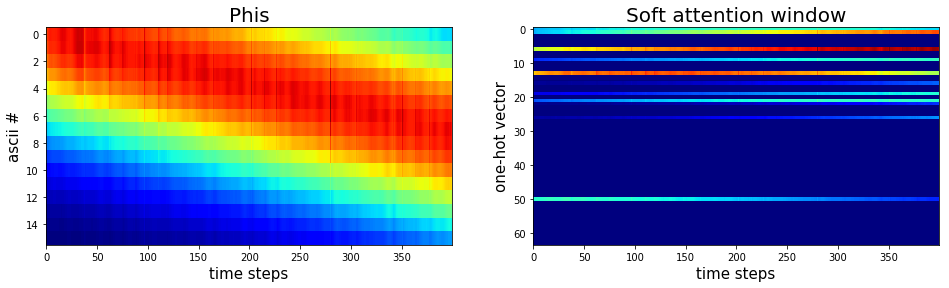

Epoch :  0  - step  10 / 548  - loss  1033.4991455078125  in  22.734052896499634
Epoch :  0  - step  20 / 548  - loss  947.0084228515625  in  21.062249422073364
Epoch :  0  - step  30 / 548  - loss  562.5426635742188  in  21.488441944122314
Epoch :  0  - step  40 / 548  - loss  583.861328125  in  20.45301914215088
Epoch :  0  - step  50 / 548  - loss  375.0226745605469  in  25.28946352005005
Epoch :  0  - step  60 / 548  - loss  326.6220397949219  in  25.131258726119995
Epoch :  0  - step  70 / 548  - loss  326.8579406738281  in  28.200225830078125
Epoch :  0  - step  80 / 548  - loss  361.2518005371094  in  26.383711576461792
Epoch :  0  - step  90 / 548  - loss  301.19244384765625  in  24.667055368423462
Epoch :  0  - step  100 / 548  - loss  211.21743774414062  in  23.772520303726196
could have seen nothing like


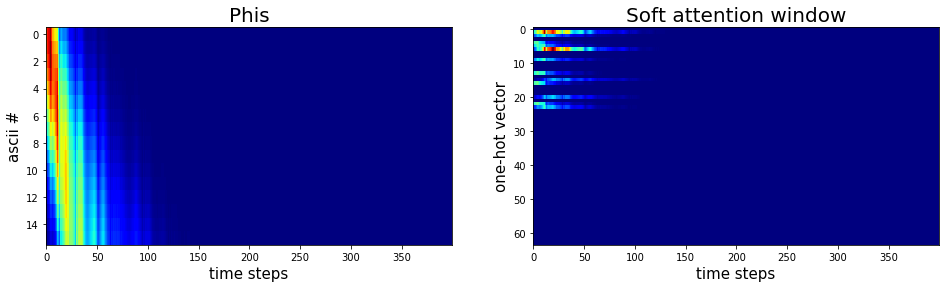

Epoch :  0  - step  110 / 548  - loss  184.3140106201172  in  21.9566068649292
Epoch :  0  - step  120 / 548  - loss  202.5870361328125  in  21.500183820724487
Epoch :  0  - step  130 / 548  - loss  142.31845092773438  in  23.397008419036865
Epoch :  0  - step  140 / 548  - loss  153.1757049560547  in  26.995830297470093
Epoch :  0  - step  150 / 548  - loss  126.2509994506836  in  26.029653787612915
Epoch :  0  - step  160 / 548  - loss  226.3490753173828  in  23.858938217163086
Epoch :  0  - step  170 / 548  - loss  182.1614227294922  in  23.85588812828064
Epoch :  0  - step  180 / 548  - loss  119.9831771850586  in  24.459791660308838
Epoch :  0  - step  190 / 548  - loss  213.1543731689453  in  23.658679962158203
Epoch :  0  - step  200 / 548  - loss  150.67845153808594  in  21.72848677635193
another of his prisoners.


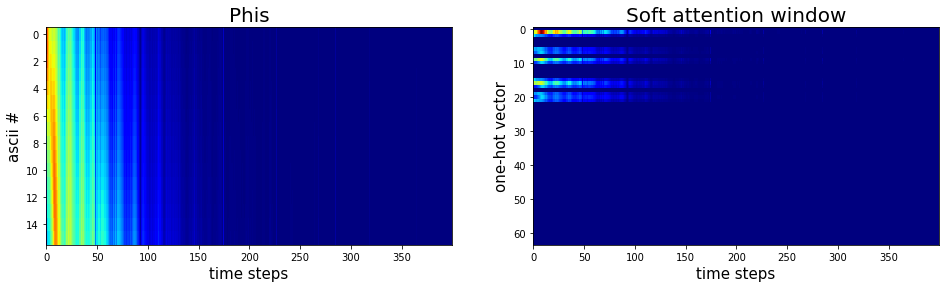

Epoch :  0  - step  210 / 548  - loss  196.26841735839844  in  20.339637756347656
Epoch :  0  - step  220 / 548  - loss  125.87890625  in  19.789083003997803
Epoch :  0  - step  230 / 548  - loss  207.4231719970703  in  20.665570497512817
Epoch :  0  - step  240 / 548  - loss  106.27687072753906  in  23.506173372268677
Epoch :  0  - step  250 / 548  - loss  227.31692504882812  in  21.489665508270264
Epoch :  0  - step  260 / 548  - loss  203.07708740234375  in  24.93112826347351
Epoch :  0  - step  270 / 548  - loss  127.48612213134766  in  21.771921634674072
Epoch :  0  - step  280 / 548  - loss  126.612548828125  in  23.323572874069214
Epoch :  0  - step  290 / 548  - loss  122.34581756591797  in  24.085702180862427
Epoch :  0  - step  300 / 548  - loss  128.7836151123047  in  28.562904834747314
and devoted friends.


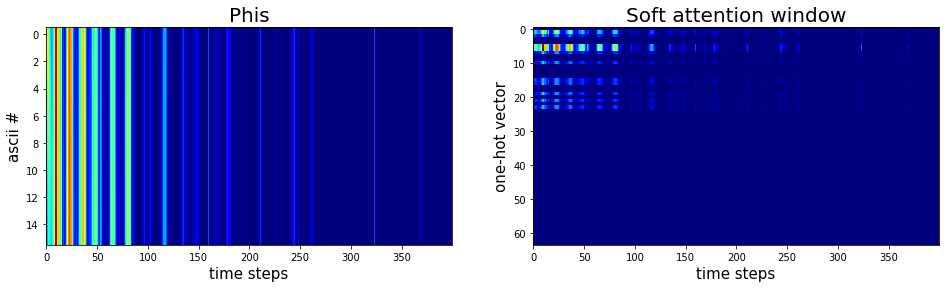

Epoch :  0  - step  310 / 548  - loss  68.19975280761719  in  26.572630882263184
Epoch :  0  - step  320 / 548  - loss  108.0177230834961  in  28.58623957633972
Epoch :  0  - step  330 / 548  - loss  129.09002685546875  in  26.56261682510376
Epoch :  0  - step  340 / 548  - loss  119.99708557128906  in  25.852821350097656
Epoch :  0  - step  350 / 548  - loss  81.28643035888672  in  24.47860813140869
Epoch :  0  - step  360 / 548  - loss  236.463134765625  in  22.716432571411133
Epoch :  0  - step  370 / 548  - loss  108.02618408203125  in  24.722668647766113
Epoch :  0  - step  380 / 548  - loss  133.90753173828125  in  26.24613881111145
Epoch :  0  - step  390 / 548  - loss  43.714195251464844  in  24.626011848449707
Epoch :  0  - step  400 / 548  - loss  157.92300415039062  in  25.096901416778564
Normally the sheets were bound in


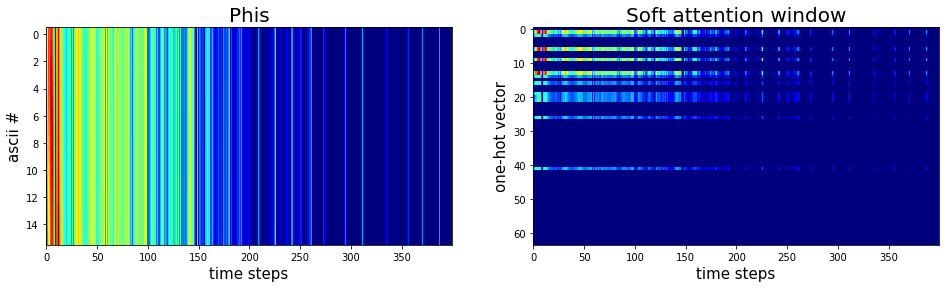

Epoch :  0  - step  410 / 548  - loss  83.46475982666016  in  25.508154153823853
Epoch :  0  - step  420 / 548  - loss  108.62477111816406  in  24.908559322357178
Epoch :  0  - step  430 / 548  - loss  96.81880950927734  in  23.85850167274475
Epoch :  0  - step  440 / 548  - loss  107.5656967163086  in  24.761918306350708
Epoch :  0  - step  450 / 548  - loss  113.4571304321289  in  24.177969217300415
Epoch :  0  - step  460 / 548  - loss  120.8874282836914  in  22.635798692703247
Epoch :  0  - step  470 / 548  - loss  101.43566131591797  in  24.794734716415405
Epoch :  0  - step  480 / 548  - loss  93.1373519897461  in  24.46147894859314
Epoch :  0  - step  490 / 548  - loss  70.25968170166016  in  23.064841508865356
Epoch :  0  - step  500 / 548  - loss  56.942684173583984  in  24.794485092163086
trees full out, except for the late, lacy


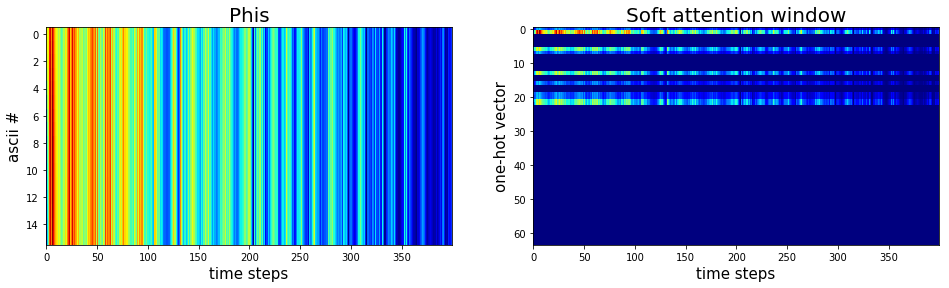

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


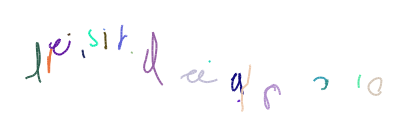

Epoch :  0  - step  510 / 548  - loss  77.11082458496094  in  266.593380689621
Epoch :  0  - step  520 / 548  - loss  82.15904998779297  in  23.491787910461426
Epoch :  0  - step  530 / 548  - loss  -29.32411766052246  in  24.08286714553833
Epoch :  0  - step  540 / 548  - loss  59.39776611328125  in  24.682353973388672
pointer reset
Epoch :  1  - step  0 / 548  - loss  40.0922737121582  in  19.296805381774902
to migrate on some occasions while any stage


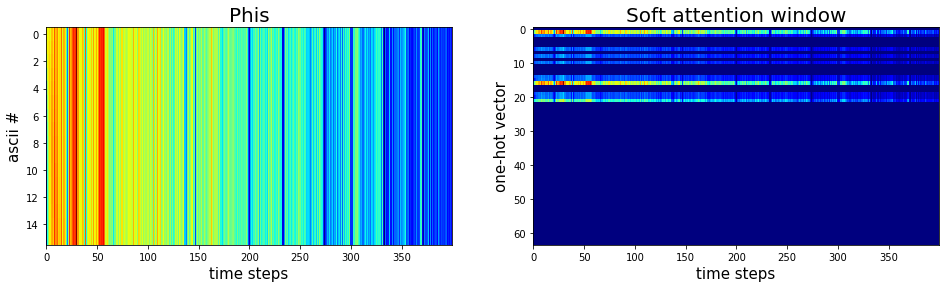

Epoch :  1  - step  10 / 548  - loss  127.85472869873047  in  24.352864265441895
Epoch :  1  - step  20 / 548  - loss  168.28579711914062  in  23.793276071548462
Epoch :  1  - step  30 / 548  - loss  63.64901351928711  in  23.324902057647705
Epoch :  1  - step  40 / 548  - loss  46.27944564819336  in  23.81563425064087
Epoch :  1  - step  50 / 548  - loss  123.45552825927734  in  24.707337379455566
Epoch :  1  - step  60 / 548  - loss  106.28266906738281  in  22.128194093704224
Epoch :  1  - step  70 / 548  - loss  25.761728286743164  in  23.04396152496338
Epoch :  1  - step  80 / 548  - loss  32.40042495727539  in  23.739625930786133
Epoch :  1  - step  90 / 548  - loss  -4.502842903137207  in  23.861393451690674
Epoch :  1  - step  100 / 548  - loss  71.74925994873047  in  23.095065593719482
could see a circular rubber object


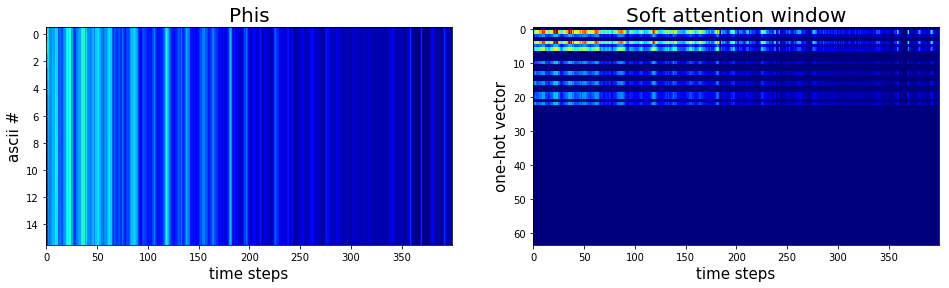

Epoch :  1  - step  110 / 548  - loss  -13.855069160461426  in  23.771389484405518
Epoch :  1  - step  120 / 548  - loss  32.64120101928711  in  23.83207678794861
Epoch :  1  - step  130 / 548  - loss  36.644371032714844  in  25.63883328437805
Epoch :  1  - step  140 / 548  - loss  58.22372055053711  in  27.311841249465942
Epoch :  1  - step  150 / 548  - loss  13.590133666992188  in  25.581648349761963
Epoch :  1  - step  160 / 548  - loss  44.0034065246582  in  26.253713607788086
Epoch :  1  - step  170 / 548  - loss  75.5635757446289  in  28.507001399993896
Epoch :  1  - step  180 / 548  - loss  16.576793670654297  in  27.19266176223755
Epoch :  1  - step  190 / 548  - loss  -3.946066379547119  in  26.136752367019653
Epoch :  1  - step  200 / 548  - loss  65.34904479980469  in  27.519134283065796
At another table nearby Mr.


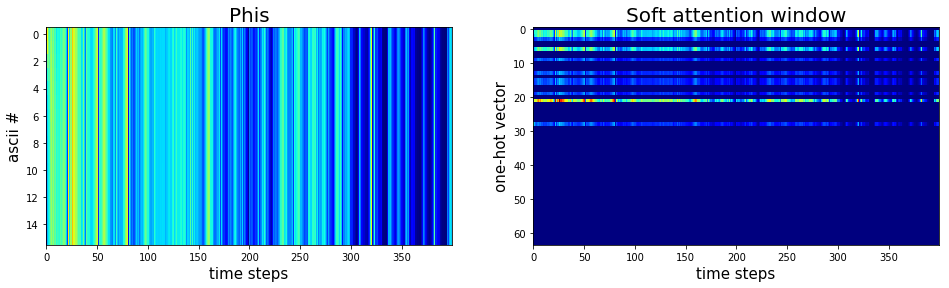

Epoch :  1  - step  210 / 548  - loss  95.27801513671875  in  24.33283805847168
Epoch :  1  - step  220 / 548  - loss  47.44775390625  in  24.13253617286682
Epoch :  1  - step  230 / 548  - loss  19.635793685913086  in  25.380332469940186
Epoch :  1  - step  240 / 548  - loss  106.54552459716797  in  24.69867706298828
Epoch :  1  - step  250 / 548  - loss  69.51915740966797  in  23.34038257598877
Epoch :  1  - step  260 / 548  - loss  91.88805389404297  in  25.596784114837646
Epoch :  1  - step  270 / 548  - loss  107.52137756347656  in  24.730161905288696
Epoch :  1  - step  280 / 548  - loss  2.7848060131073  in  22.979299545288086
Epoch :  1  - step  290 / 548  - loss  -39.82052230834961  in  24.030062198638916
Epoch :  1  - step  300 / 548  - loss  67.35372161865234  in  24.514844179153442
I picked up the shirt. The


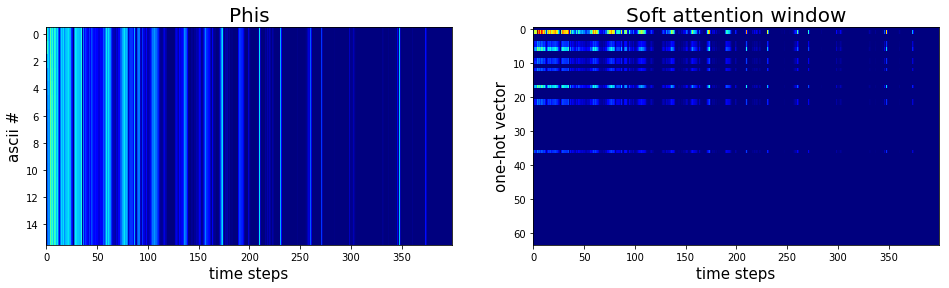

Epoch :  1  - step  310 / 548  - loss  44.47216796875  in  23.958911418914795
Epoch :  1  - step  320 / 548  - loss  115.31884002685547  in  23.8755304813385
Epoch :  1  - step  330 / 548  - loss  37.32194900512695  in  23.607299089431763
Epoch :  1  - step  340 / 548  - loss  35.4234504699707  in  22.18105387687683
Epoch :  1  - step  350 / 548  - loss  94.4214859008789  in  22.79369616508484
Epoch :  1  - step  360 / 548  - loss  -12.996170043945312  in  24.92207670211792
Epoch :  1  - step  370 / 548  - loss  35.65531539916992  in  25.32823348045349
Epoch :  1  - step  380 / 548  - loss  -4.407386302947998  in  23.772958517074585
Epoch :  1  - step  390 / 548  - loss  -6.206523895263672  in  23.002838373184204
Epoch :  1  - step  400 / 548  - loss  32.94458770751953  in  21.911962270736694
industrial design, in Petty France, for


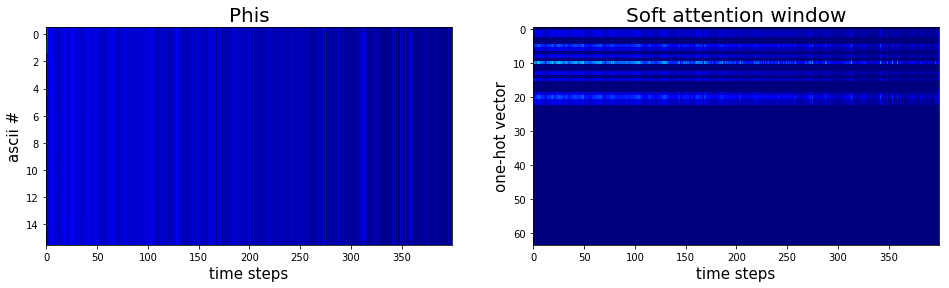

Epoch :  1  - step  410 / 548  - loss  -4.394723415374756  in  24.44612431526184
Epoch :  1  - step  420 / 548  - loss  9.955598831176758  in  24.495282649993896
Epoch :  1  - step  430 / 548  - loss  26.460317611694336  in  21.667574882507324
Epoch :  1  - step  440 / 548  - loss  33.40676498413086  in  21.384618759155273
Epoch :  1  - step  450 / 548  - loss  -5.067355632781982  in  23.76396417617798
Epoch :  1  - step  460 / 548  - loss  60.4095344543457  in  22.3519024848938
Epoch :  1  - step  470 / 548  - loss  -19.990507125854492  in  22.83765983581543
Epoch :  1  - step  480 / 548  - loss  -17.836746215820312  in  23.279256105422974
Epoch :  1  - step  490 / 548  - loss  74.40238952636719  in  22.38446593284607
Epoch :  1  - step  500 / 548  - loss  15.491942405700684  in  24.98475480079651
under this head will not


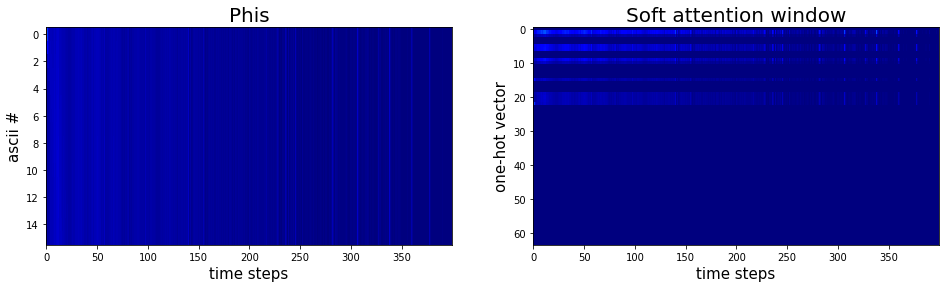

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


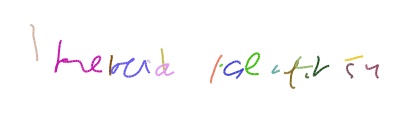

Epoch :  1  - step  510 / 548  - loss  -25.18111228942871  in  282.0904951095581
Epoch :  1  - step  520 / 548  - loss  54.85422897338867  in  23.259473085403442
Epoch :  1  - step  530 / 548  - loss  -45.181819915771484  in  23.940917491912842
Epoch :  1  - step  540 / 548  - loss  -34.17551803588867  in  24.770827293395996
pointer reset
Epoch :  2  - step  0 / 548  - loss  -0.8670749664306641  in  21.223918914794922
" I be " will go . The main topic


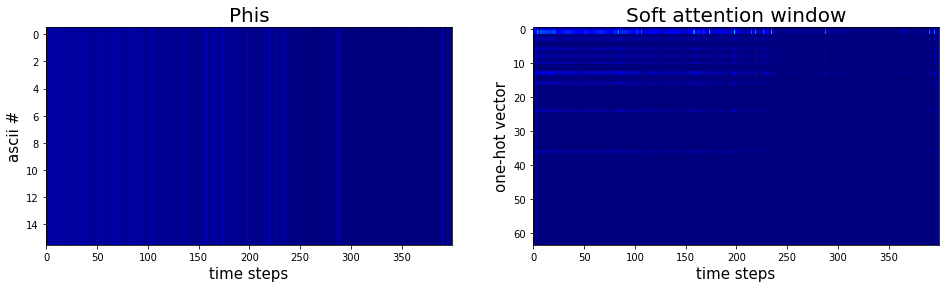

Epoch :  2  - step  10 / 548  - loss  54.90861129760742  in  26.430444955825806
Epoch :  2  - step  20 / 548  - loss  37.2736930847168  in  25.86875081062317
Epoch :  2  - step  30 / 548  - loss  -15.078081130981445  in  27.40741491317749
Epoch :  2  - step  40 / 548  - loss  -23.56593132019043  in  24.605766773223877
Epoch :  2  - step  50 / 548  - loss  -73.2451171875  in  26.06511878967285
Epoch :  2  - step  60 / 548  - loss  -56.00191879272461  in  24.104291439056396
Epoch :  2  - step  70 / 548  - loss  10.937394142150879  in  24.720722675323486
Epoch :  2  - step  80 / 548  - loss  0.7088281512260437  in  25.80288028717041
Epoch :  2  - step  90 / 548  - loss  -28.290542602539062  in  23.596646785736084
Epoch :  2  - step  100 / 548  - loss  13.87613582611084  in  23.350366353988647
be called a plot". Dr. Banda,


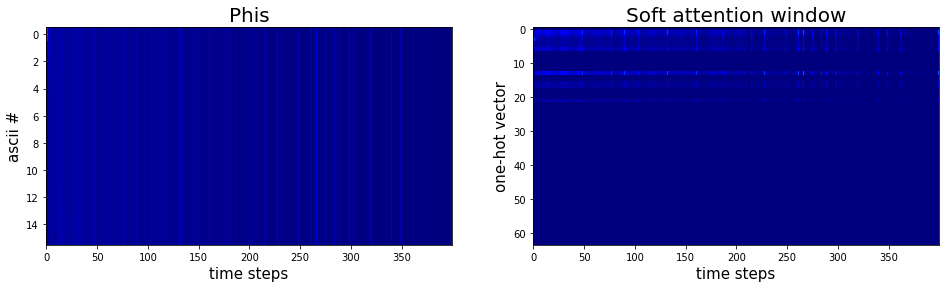

Epoch :  2  - step  110 / 548  - loss  3.9100005626678467  in  27.375970602035522
Epoch :  2  - step  120 / 548  - loss  -11.51390266418457  in  23.403383493423462
Epoch :  2  - step  130 / 548  - loss  -34.02334213256836  in  23.07704734802246
Epoch :  2  - step  140 / 548  - loss  19.534122467041016  in  24.57327651977539
Epoch :  2  - step  150 / 548  - loss  18.467159271240234  in  28.496663808822632
Epoch :  2  - step  160 / 548  - loss  -74.5339584350586  in  27.849475622177124
Epoch :  2  - step  170 / 548  - loss  -40.71757888793945  in  27.849852561950684
Epoch :  2  - step  180 / 548  - loss  9.672408103942871  in  27.17006254196167
Epoch :  2  - step  190 / 548  - loss  2.8894360065460205  in  25.109148740768433
Epoch :  2  - step  200 / 548  - loss  53.68156051635742  in  22.092798471450806
she jerked. "Wales! I


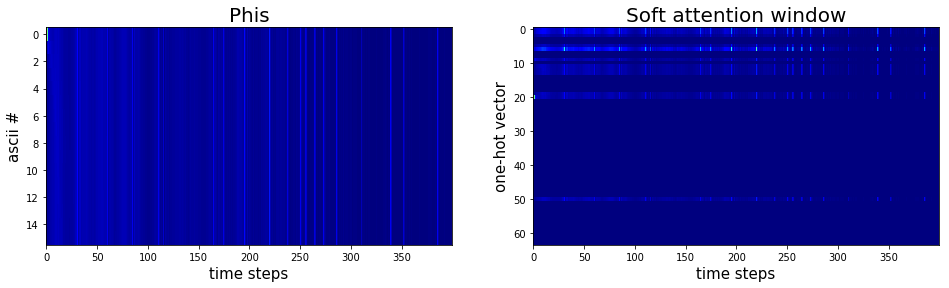

Epoch :  2  - step  210 / 548  - loss  -2.9686267375946045  in  29.669713258743286
Epoch :  2  - step  220 / 548  - loss  -17.515634536743164  in  24.85540509223938
Epoch :  2  - step  230 / 548  - loss  6.44729471206665  in  22.71602511405945
Epoch :  2  - step  240 / 548  - loss  -24.34170913696289  in  23.53388738632202
Epoch :  2  - step  250 / 548  - loss  -3.464977264404297  in  21.539708137512207
Epoch :  2  - step  260 / 548  - loss  -115.46868133544922  in  23.388797998428345
Epoch :  2  - step  270 / 548  - loss  -55.06185531616211  in  26.271900415420532
Epoch :  2  - step  280 / 548  - loss  -34.66305923461914  in  25.765708208084106
Epoch :  2  - step  290 / 548  - loss  -50.26995086669922  in  26.947976112365723
Epoch :  2  - step  300 / 548  - loss  6.303009033203125  in  24.913745403289795
more of national temperament


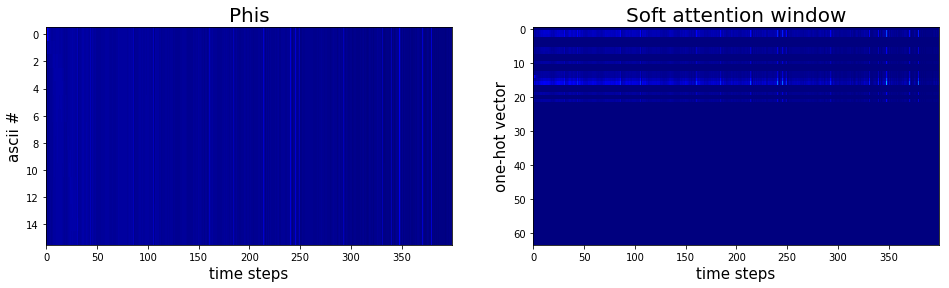

Epoch :  2  - step  310 / 548  - loss  -27.098962783813477  in  24.774709939956665
Epoch :  2  - step  320 / 548  - loss  -6.074046611785889  in  24.988932847976685
Epoch :  2  - step  330 / 548  - loss  -53.87575149536133  in  25.220834016799927
Epoch :  2  - step  340 / 548  - loss  -121.10064697265625  in  26.28766942024231
Epoch :  2  - step  350 / 548  - loss  -23.811643600463867  in  25.67175841331482
Epoch :  2  - step  360 / 548  - loss  -52.70852279663086  in  27.555006504058838
Epoch :  2  - step  370 / 548  - loss  -74.5230941772461  in  25.865037202835083
Epoch :  2  - step  380 / 548  - loss  39.47687911987305  in  26.122604608535767
Epoch :  2  - step  390 / 548  - loss  -71.45999145507812  in  27.16219210624695
Epoch :  2  - step  400 / 548  - loss  -47.378604888916016  in  25.546275854110718
To be able to say "New York next week" is


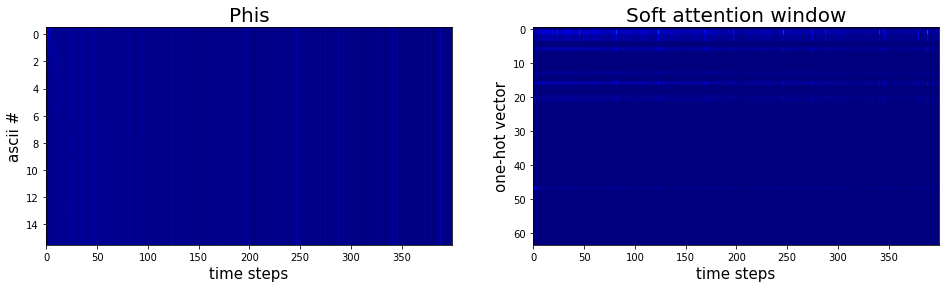

Epoch :  2  - step  410 / 548  - loss  -50.16636657714844  in  24.83241868019104
Epoch :  2  - step  420 / 548  - loss  -87.81204223632812  in  24.268354892730713
Epoch :  2  - step  430 / 548  - loss  -35.55302810668945  in  24.809893369674683
Epoch :  2  - step  440 / 548  - loss  -36.24044418334961  in  22.946327686309814
Epoch :  2  - step  450 / 548  - loss  -80.73531341552734  in  23.141891479492188
Epoch :  2  - step  460 / 548  - loss  -63.550533294677734  in  24.80173087120056
Epoch :  2  - step  470 / 548  - loss  -6.539225101470947  in  23.56604027748108
Epoch :  2  - step  480 / 548  - loss  -94.6640853881836  in  22.606139421463013
Epoch :  2  - step  490 / 548  - loss  -49.691280364990234  in  23.55742120742798
Epoch :  2  - step  500 / 548  - loss  -21.71160316467285  in  24.23908281326294
power at the foreign Office.


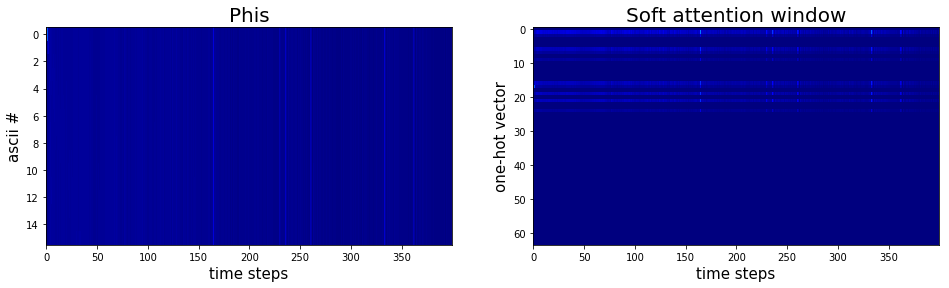

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


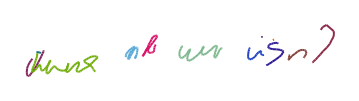

Epoch :  2  - step  510 / 548  - loss  -61.88703155517578  in  258.1154634952545
Epoch :  2  - step  520 / 548  - loss  -41.73456573486328  in  21.94363260269165
Epoch :  2  - step  530 / 548  - loss  -66.04818725585938  in  22.306488037109375
Epoch :  2  - step  540 / 548  - loss  -49.325862884521484  in  24.653728246688843
pointer reset
Epoch :  3  - step  0 / 548  - loss  -51.86226272583008  in  18.222975492477417
"So-long then till tomorrow, Miss


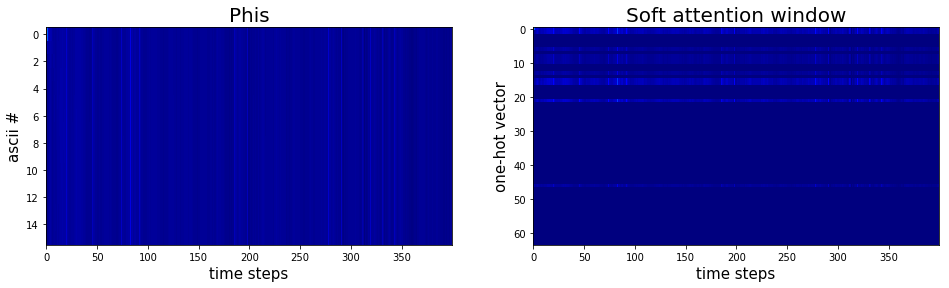

Epoch :  3  - step  10 / 548  - loss  -35.45005798339844  in  22.743656873703003
Epoch :  3  - step  20 / 548  - loss  -50.25728988647461  in  21.8756422996521
Epoch :  3  - step  30 / 548  - loss  -47.590518951416016  in  22.227253913879395
Epoch :  3  - step  40 / 548  - loss  -18.03281593322754  in  22.885594606399536
Epoch :  3  - step  50 / 548  - loss  -7.947196960449219  in  20.42576241493225
Epoch :  3  - step  60 / 548  - loss  -39.73335647583008  in  20.464488744735718
Epoch :  3  - step  70 / 548  - loss  -39.03594970703125  in  20.605658769607544
Epoch :  3  - step  80 / 548  - loss  -13.816986083984375  in  20.531067371368408
Epoch :  3  - step  90 / 548  - loss  8.331841468811035  in  20.557422876358032
Epoch :  3  - step  100 / 548  - loss  -48.11417770385742  in  20.48718810081482
the sinking of the great ocean liner ,


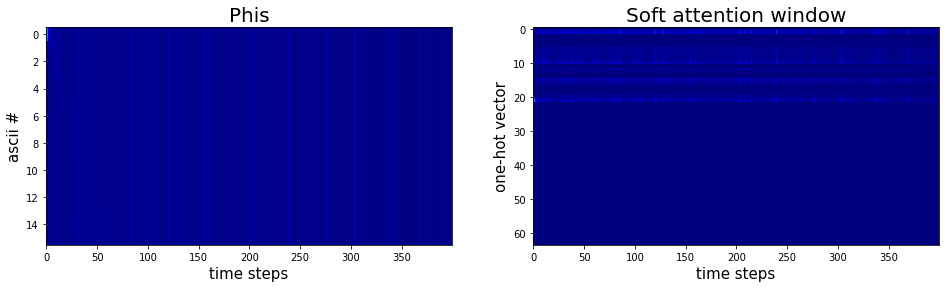

Epoch :  3  - step  110 / 548  - loss  -38.01896667480469  in  20.915257692337036
Epoch :  3  - step  120 / 548  - loss  -16.801063537597656  in  20.52624797821045
Epoch :  3  - step  130 / 548  - loss  -60.36558151245117  in  20.62488102912903
Epoch :  3  - step  140 / 548  - loss  0.43206197023391724  in  20.544620275497437
Epoch :  3  - step  150 / 548  - loss  -123.63551330566406  in  20.407991647720337
Epoch :  3  - step  160 / 548  - loss  -73.87395477294922  in  20.59845519065857
Epoch :  3  - step  170 / 548  - loss  -99.10751342773438  in  20.561792135238647
Epoch :  3  - step  180 / 548  - loss  -32.28491973876953  in  20.31279444694519
Epoch :  3  - step  190 / 548  - loss  -37.91889572143555  in  21.28412389755249
Epoch :  3  - step  200 / 548  - loss  -40.30745315551758  in  23.83408761024475
him until he died just after the


/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


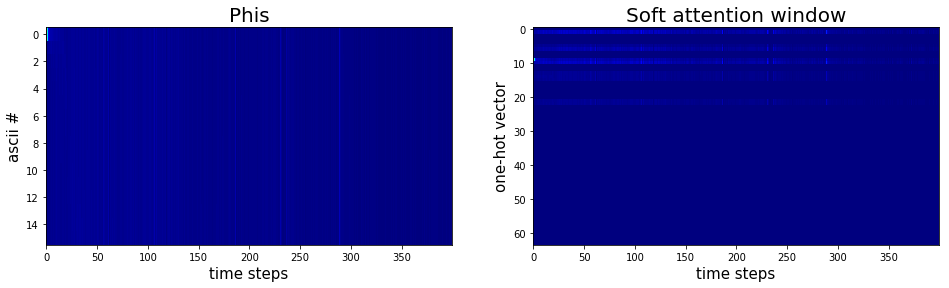

Epoch :  3  - step  210 / 548  - loss  14.23966121673584  in  23.300971746444702
Epoch :  3  - step  220 / 548  - loss  -35.94572448730469  in  23.941930055618286
Epoch :  3  - step  230 / 548  - loss  -105.11498260498047  in  23.349493265151978
Epoch :  3  - step  240 / 548  - loss  -15.990384101867676  in  23.877801656723022
Epoch :  3  - step  250 / 548  - loss  -55.25165557861328  in  24.12269401550293
Epoch :  3  - step  260 / 548  - loss  -59.81577682495117  in  24.165361166000366
Epoch :  3  - step  270 / 548  - loss  -21.105106353759766  in  22.943848609924316
Epoch :  3  - step  280 / 548  - loss  -83.57677459716797  in  22.211641311645508
Epoch :  3  - step  290 / 548  - loss  34.059505462646484  in  22.146241664886475
Epoch :  3  - step  300 / 548  - loss  -40.44655990600586  in  22.133370637893677
activists of Nkrumah's convention


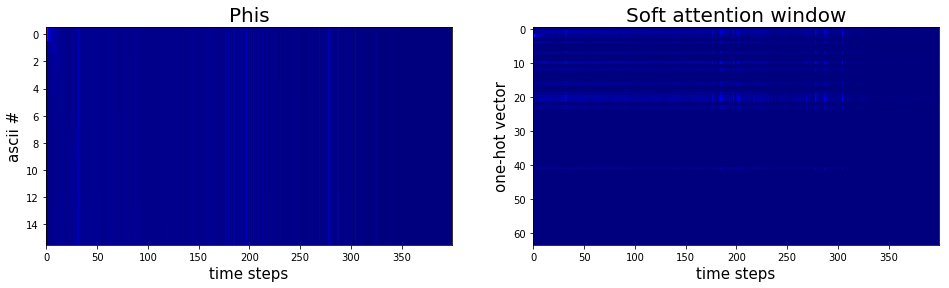

Epoch :  3  - step  310 / 548  - loss  -62.76523971557617  in  22.724681854248047
Epoch :  3  - step  320 / 548  - loss  -44.91341018676758  in  23.1756649017334
Epoch :  3  - step  330 / 548  - loss  -66.44786834716797  in  23.54075860977173
Epoch :  3  - step  340 / 548  - loss  -18.507396697998047  in  22.76936364173889
Epoch :  3  - step  350 / 548  - loss  -55.42100143432617  in  22.232905387878418
Epoch :  3  - step  360 / 548  - loss  -86.66756439208984  in  22.09727716445923
Epoch :  3  - step  370 / 548  - loss  -7.609378337860107  in  22.515360355377197
Epoch :  3  - step  380 / 548  - loss  7.225250244140625  in  22.64522409439087
Epoch :  3  - step  390 / 548  - loss  -19.0789852142334  in  23.01184892654419
Epoch :  3  - step  400 / 548  - loss  -38.548370361328125  in  20.447484493255615
also reduce the gravimetric recovery of


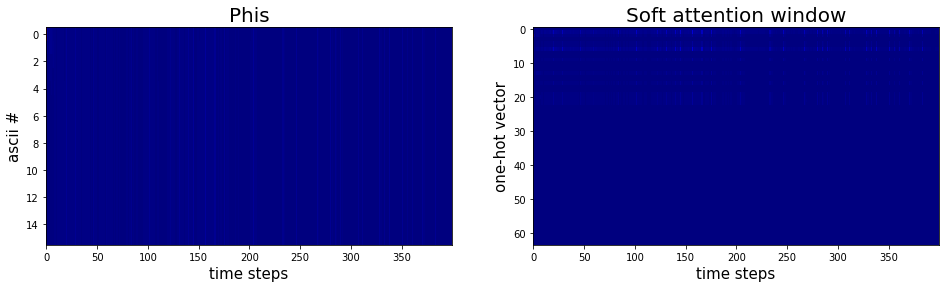

Epoch :  3  - step  410 / 548  - loss  -76.31544494628906  in  21.044753074645996
Epoch :  3  - step  420 / 548  - loss  -70.9288558959961  in  20.361263275146484
Epoch :  3  - step  430 / 548  - loss  -27.079370498657227  in  23.714046716690063
Epoch :  3  - step  440 / 548  - loss  -37.973079681396484  in  23.081467866897583
Epoch :  3  - step  450 / 548  - loss  -77.6181869506836  in  24.367403507232666
Epoch :  3  - step  460 / 548  - loss  -52.69624710083008  in  22.306177854537964
Epoch :  3  - step  470 / 548  - loss  -66.36199188232422  in  22.822834253311157
Epoch :  3  - step  480 / 548  - loss  -118.1583023071289  in  21.99245572090149
Epoch :  3  - step  490 / 548  - loss  -30.206165313720703  in  21.003360986709595
Epoch :  3  - step  500 / 548  - loss  -88.56900024414062  in  21.79901647567749
as shown in Fig. 4. Build the


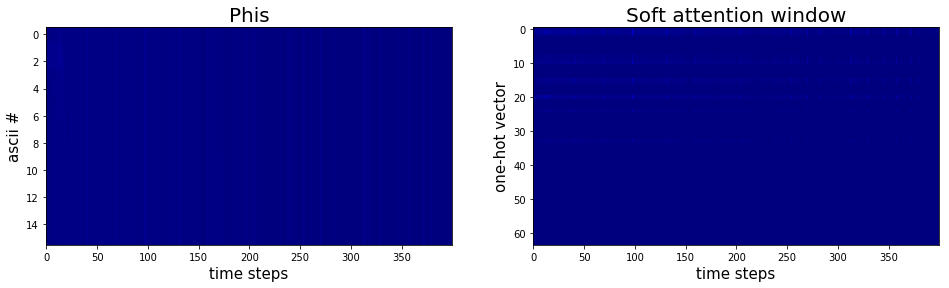

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


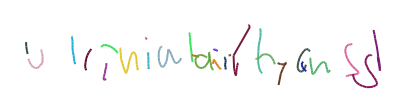

Epoch :  3  - step  510 / 548  - loss  -99.74468994140625  in  223.56284284591675
Epoch :  3  - step  520 / 548  - loss  -13.19105052947998  in  19.881677627563477
Epoch :  3  - step  530 / 548  - loss  -26.66617202758789  in  19.95029330253601
Epoch :  3  - step  540 / 548  - loss  -102.64015197753906  in  19.787195444107056
pointer reset
Epoch :  4  - step  0 / 548  - loss  -57.88521957397461  in  16.011780738830566
new image. He was mercilessly trounced


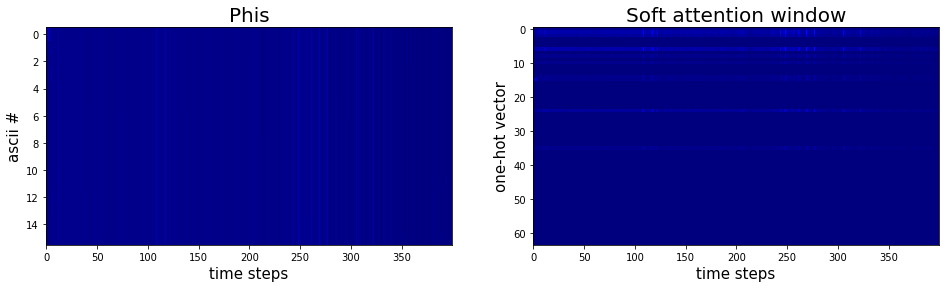

Epoch :  4  - step  10 / 548  - loss  -79.19441986083984  in  20.250574827194214
Epoch :  4  - step  20 / 548  - loss  -78.4863510131836  in  20.347922801971436
Epoch :  4  - step  30 / 548  - loss  -52.5714111328125  in  21.822274923324585
Epoch :  4  - step  40 / 548  - loss  -40.58205032348633  in  20.70600938796997
Epoch :  4  - step  50 / 548  - loss  -60.416378021240234  in  21.394736289978027
Epoch :  4  - step  60 / 548  - loss  -27.568225860595703  in  19.839695692062378
Epoch :  4  - step  70 / 548  - loss  -34.09564208984375  in  19.762086153030396
Epoch :  4  - step  80 / 548  - loss  9.295701026916504  in  19.65297794342041
Epoch :  4  - step  90 / 548  - loss  -46.173255920410156  in  19.863468647003174
Epoch :  4  - step  100 / 548  - loss  -40.25657272338867  in  19.74409770965576
Tafira for the next few months,


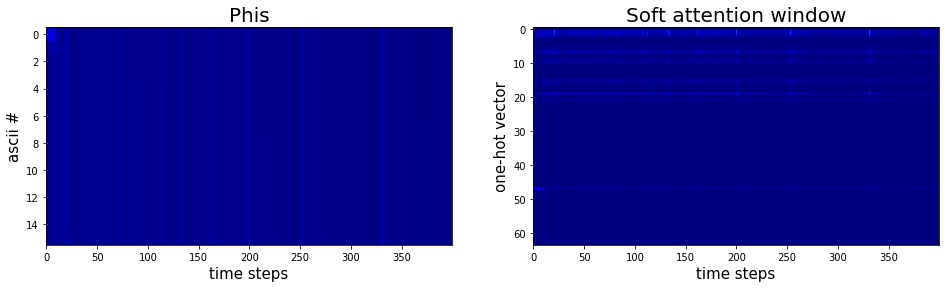

Epoch :  4  - step  110 / 548  - loss  -92.2461166381836  in  20.10691213607788
Epoch :  4  - step  120 / 548  - loss  -85.08047485351562  in  19.65120816230774
Epoch :  4  - step  130 / 548  - loss  -61.198238372802734  in  20.030935764312744
Epoch :  4  - step  140 / 548  - loss  -21.890060424804688  in  19.76401972770691
Epoch :  4  - step  150 / 548  - loss  -90.07124328613281  in  19.725545644760132
Epoch :  4  - step  160 / 548  - loss  -79.81907653808594  in  19.712793588638306
Epoch :  4  - step  170 / 548  - loss  -44.43075180053711  in  19.78798747062683
Epoch :  4  - step  180 / 548  - loss  -94.98912811279297  in  20.107630252838135
Epoch :  4  - step  190 / 548  - loss  -33.83009719848633  in  20.567902088165283
Epoch :  4  - step  200 / 548  - loss  -26.021575927734375  in  20.175743103027344
French, " I shall be obliges to lift you 


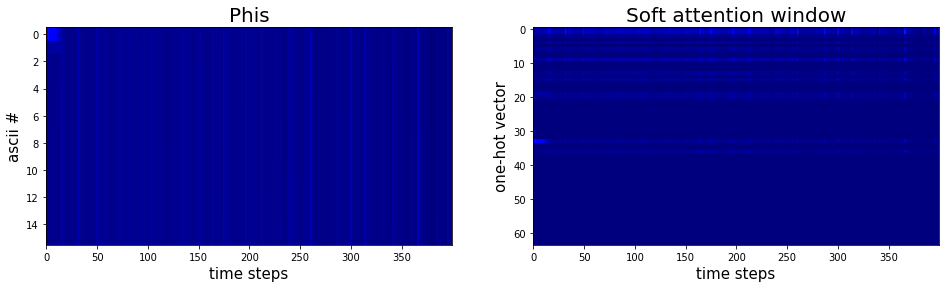

Epoch :  4  - step  210 / 548  - loss  -73.89994049072266  in  21.41451334953308
Epoch :  4  - step  220 / 548  - loss  -67.66413116455078  in  19.746668338775635
Epoch :  4  - step  230 / 548  - loss  -42.25466537475586  in  19.852097511291504
Epoch :  4  - step  240 / 548  - loss  -115.04803466796875  in  19.820549488067627
Epoch :  4  - step  250 / 548  - loss  -99.03609466552734  in  19.84337306022644
Epoch :  4  - step  260 / 548  - loss  -71.09891510009766  in  19.623358011245728
Epoch :  4  - step  270 / 548  - loss  -68.81304931640625  in  19.64597988128662
Epoch :  4  - step  280 / 548  - loss  -44.44696807861328  in  19.802249431610107
Epoch :  4  - step  290 / 548  - loss  -16.339126586914062  in  19.664692163467407
Epoch :  4  - step  300 / 548  - loss  -119.16474914550781  in  19.521453857421875
prescription. The irritants associated with


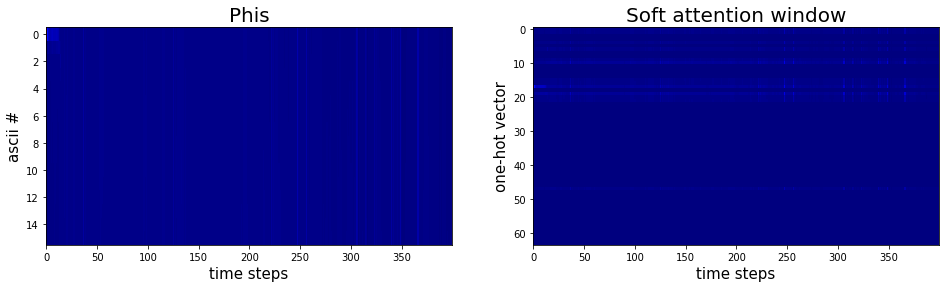

Epoch :  4  - step  310 / 548  - loss  -90.31893157958984  in  20.063501834869385
Epoch :  4  - step  320 / 548  - loss  -141.72894287109375  in  19.69099736213684
Epoch :  4  - step  330 / 548  - loss  -30.850027084350586  in  19.60387134552002
Epoch :  4  - step  340 / 548  - loss  -53.25503158569336  in  19.70972752571106
Epoch :  4  - step  350 / 548  - loss  -37.5256462097168  in  19.85306978225708
Epoch :  4  - step  360 / 548  - loss  -108.58436584472656  in  19.672728538513184
Epoch :  4  - step  370 / 548  - loss  -18.937898635864258  in  19.706357717514038
Epoch :  4  - step  380 / 548  - loss  -147.72805786132812  in  19.671639680862427
Epoch :  4  - step  390 / 548  - loss  -130.55950927734375  in  19.653098583221436
Epoch :  4  - step  400 / 548  - loss  -49.6990966796875  in  19.629584550857544
door and wandered about inside, 


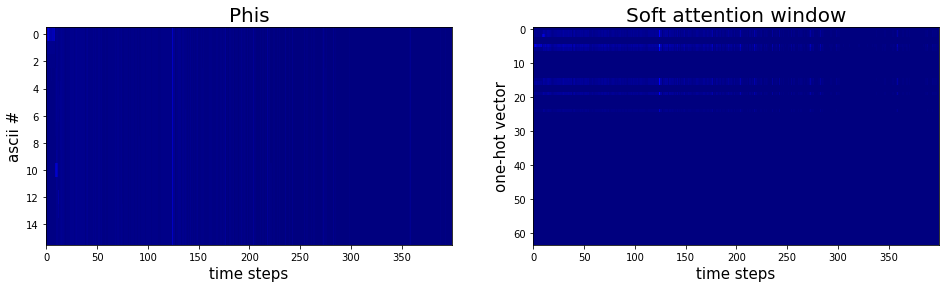

Epoch :  4  - step  410 / 548  - loss  -81.02862548828125  in  20.11642336845398
Epoch :  4  - step  420 / 548  - loss  -74.34124755859375  in  19.570972442626953
Epoch :  4  - step  430 / 548  - loss  -66.37102508544922  in  19.66210675239563
Epoch :  4  - step  440 / 548  - loss  -161.1567840576172  in  19.892453908920288
Epoch :  4  - step  450 / 548  - loss  -87.41889953613281  in  19.697654247283936
Epoch :  4  - step  460 / 548  - loss  -69.14476013183594  in  19.56387424468994
Epoch :  4  - step  470 / 548  - loss  -150.5013427734375  in  19.704840898513794
Epoch :  4  - step  480 / 548  - loss  -43.416107177734375  in  19.59786891937256
Epoch :  4  - step  490 / 548  - loss  -79.79682922363281  in  19.690061569213867
Epoch :  4  - step  500 / 548  - loss  6.418900966644287  in  19.720595359802246
Well, as you can see, it isn't


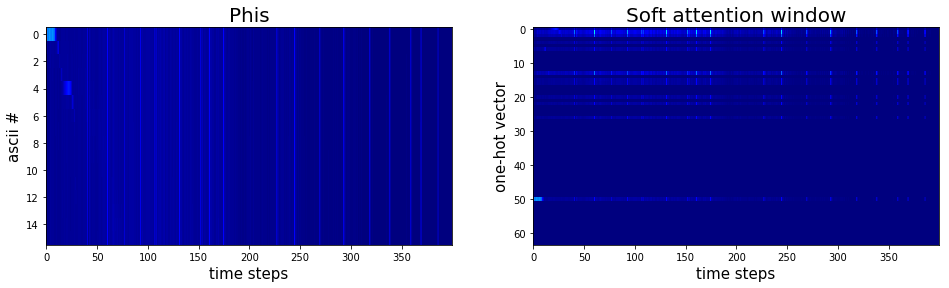

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


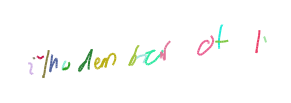

Epoch :  4  - step  510 / 548  - loss  -30.84619140625  in  218.76050806045532
Epoch :  4  - step  520 / 548  - loss  -69.75684356689453  in  19.78393530845642
Epoch :  4  - step  530 / 548  - loss  -89.2896957397461  in  19.69842553138733
Epoch :  4  - step  540 / 548  - loss  -42.74452209472656  in  19.626107454299927
pointer reset
Epoch :  5  - step  0 / 548  - loss  -83.51339721679688  in  15.677096605300903
image is to be seen under


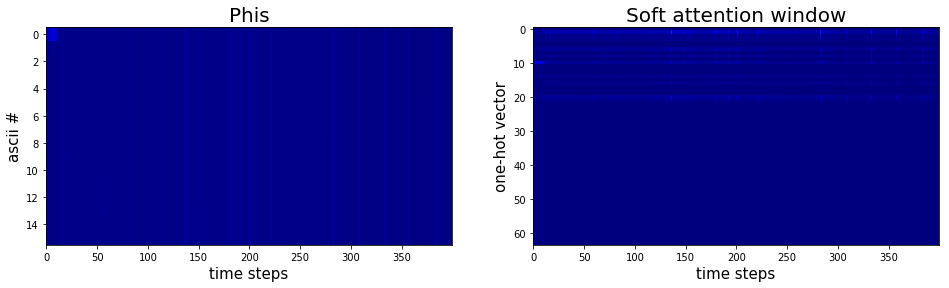

Epoch :  5  - step  10 / 548  - loss  -54.9492073059082  in  20.047961711883545
Epoch :  5  - step  20 / 548  - loss  60.01205062866211  in  19.662378787994385
Epoch :  5  - step  30 / 548  - loss  nan  in  19.76556134223938
Epoch :  5  - step  40 / 548  - loss  nan  in  19.764277696609497
Epoch :  5  - step  50 / 548  - loss  nan  in  19.595075368881226
Epoch :  5  - step  60 / 548  - loss  nan  in  19.619069576263428
Epoch :  5  - step  70 / 548  - loss  nan  in  19.649270057678223
Epoch :  5  - step  80 / 548  - loss  nan  in  19.556530475616455
Epoch :  5  - step  90 / 548  - loss  nan  in  19.634466648101807
Epoch :  5  - step  100 / 548  - loss  nan  in  19.571118354797363
the fact remains that get


/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/gnocchi/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False

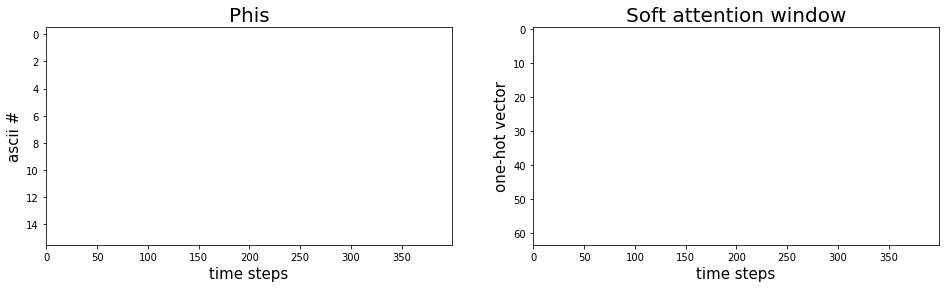

Epoch :  5  - step  110 / 548  - loss  nan  in  20.28928852081299
Epoch :  5  - step  120 / 548  - loss  nan  in  20.07800054550171
Epoch :  5  - step  130 / 548  - loss  nan  in  19.610860586166382
Epoch :  5  - step  140 / 548  - loss  nan  in  20.359785318374634
Epoch :  5  - step  150 / 548  - loss  nan  in  20.008245944976807
Epoch :  5  - step  160 / 548  - loss  nan  in  19.700936317443848
Epoch :  5  - step  170 / 548  - loss  nan  in  19.842549085617065
Epoch :  5  - step  180 / 548  - loss  nan  in  19.631391763687134
Epoch :  5  - step  190 / 548  - loss  nan  in  19.623740673065186
Epoch :  5  - step  200 / 548  - loss  nan  in  19.72283935546875
"I don't know whether Harold


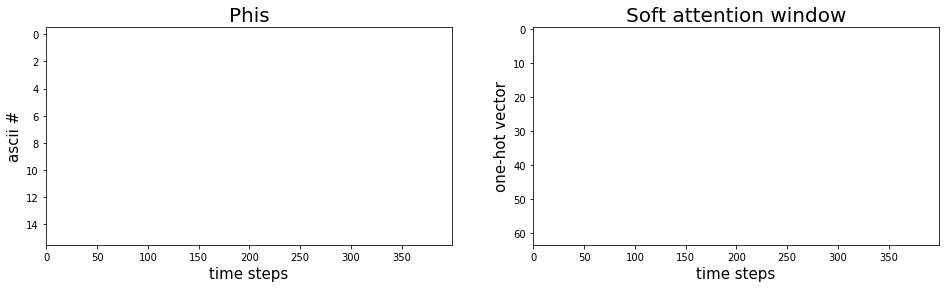

Epoch :  5  - step  210 / 548  - loss  nan  in  20.145376682281494
Epoch :  5  - step  220 / 548  - loss  nan  in  19.60107159614563
Epoch :  5  - step  230 / 548  - loss  nan  in  19.650280475616455
Epoch :  5  - step  240 / 548  - loss  nan  in  19.77983522415161
Epoch :  5  - step  250 / 548  - loss  nan  in  19.591291427612305
Epoch :  5  - step  260 / 548  - loss  nan  in  19.622065544128418
Epoch :  5  - step  270 / 548  - loss  nan  in  19.80644154548645
Epoch :  5  - step  280 / 548  - loss  nan  in  19.648171186447144
Epoch :  5  - step  290 / 548  - loss  nan  in  19.578983068466187
Epoch :  5  - step  300 / 548  - loss  nan  in  19.67800498008728
because these are permanent


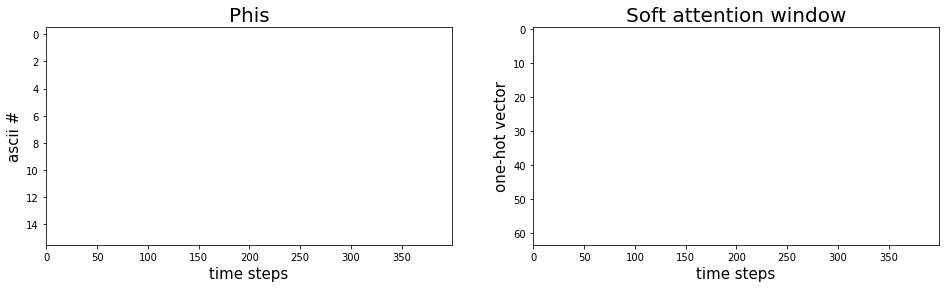

Epoch :  5  - step  310 / 548  - loss  nan  in  20.030606031417847
Epoch :  5  - step  320 / 548  - loss  nan  in  19.537124395370483
Epoch :  5  - step  330 / 548  - loss  nan  in  19.723787784576416
Epoch :  5  - step  340 / 548  - loss  nan  in  19.842026233673096
Epoch :  5  - step  350 / 548  - loss  nan  in  19.622410535812378
Epoch :  5  - step  360 / 548  - loss  nan  in  19.632287740707397
Epoch :  5  - step  370 / 548  - loss  nan  in  19.679072380065918
Epoch :  5  - step  380 / 548  - loss  nan  in  19.554352283477783
Epoch :  5  - step  390 / 548  - loss  nan  in  19.679154872894287
Epoch :  5  - step  400 / 548  - loss  nan  in  19.766347408294678
It was the opening for a little


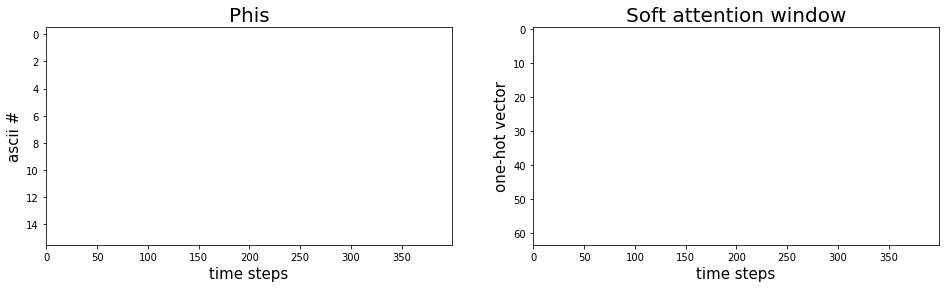

Epoch :  5  - step  410 / 548  - loss  nan  in  19.98193645477295
Epoch :  5  - step  420 / 548  - loss  nan  in  19.657143115997314
Epoch :  5  - step  430 / 548  - loss  nan  in  19.593202829360962
Epoch :  5  - step  440 / 548  - loss  nan  in  19.743594646453857
Epoch :  5  - step  450 / 548  - loss  nan  in  19.70558524131775
Epoch :  5  - step  460 / 548  - loss  nan  in  19.623268127441406
Epoch :  5  - step  470 / 548  - loss  nan  in  19.649656772613525
Epoch :  5  - step  480 / 548  - loss  nan  in  19.5678551197052
Epoch :  5  - step  490 / 548  - loss  nan  in  19.593794107437134
Epoch :  5  - step  500 / 548  - loss  nan  in  19.586965799331665
to let older employees attend day-release


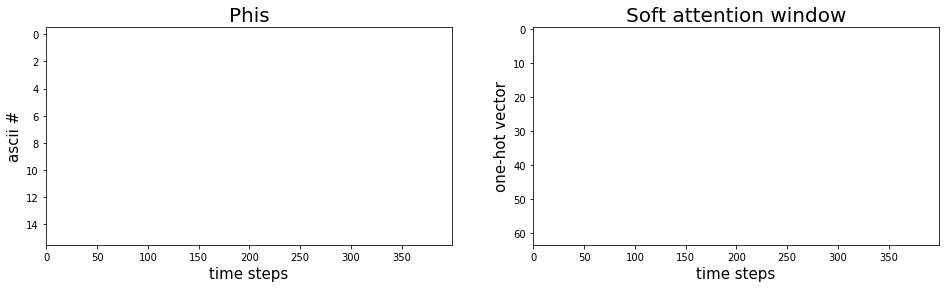

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

/home/gnocchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in less
/home/gnocchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.


RuntimeError: invalid argument 1: must be >= 0 and <= 1 at /opt/conda/conda-bld/pytorch_1535493744281/work/aten/src/TH/THRandom.cpp:314

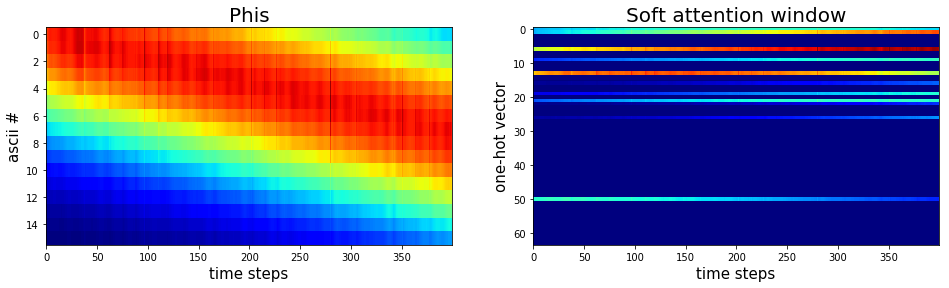

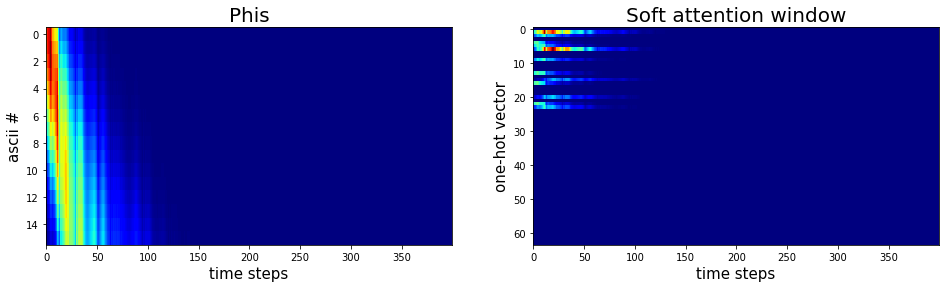

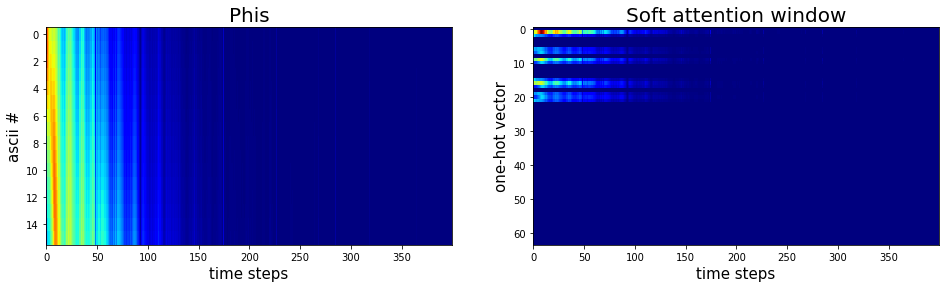

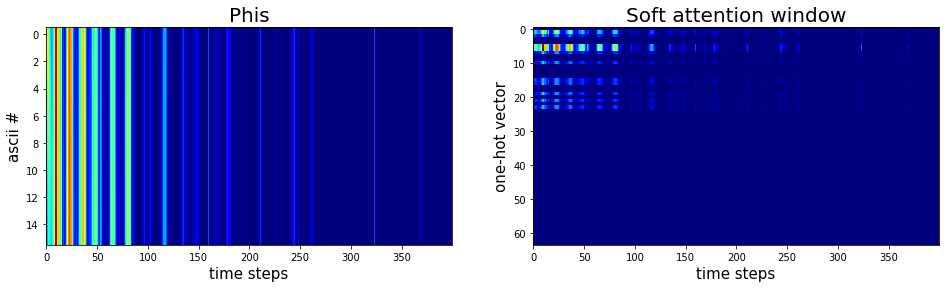

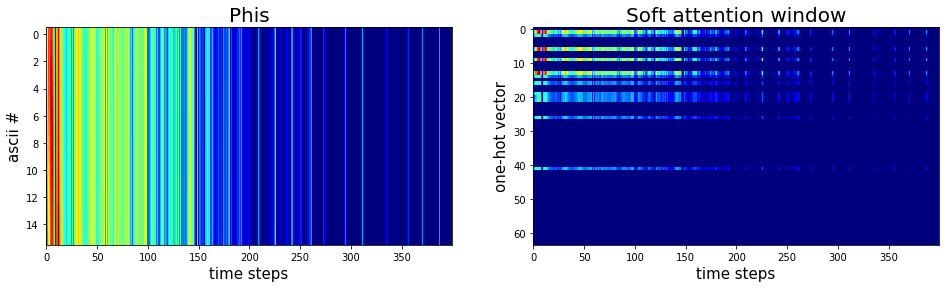

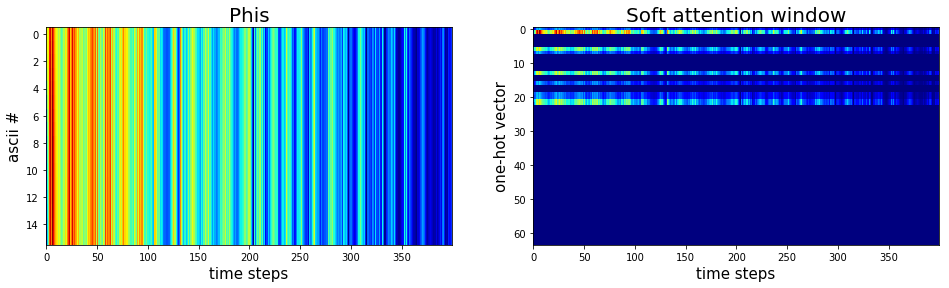

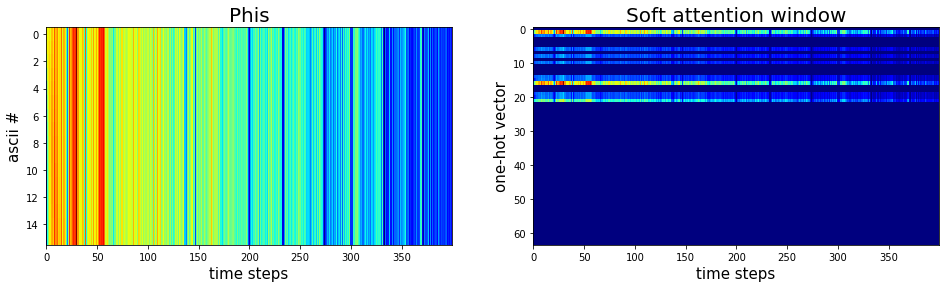

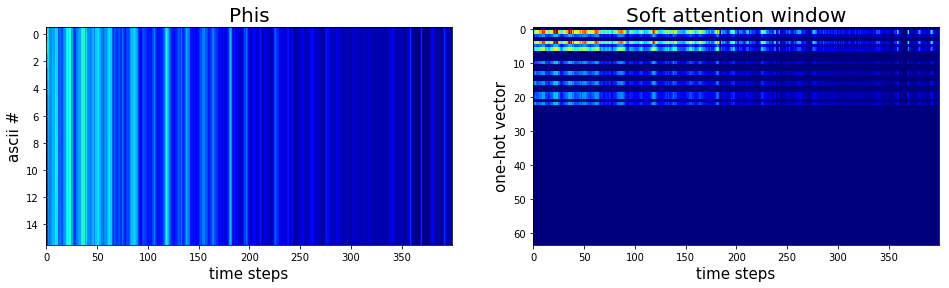

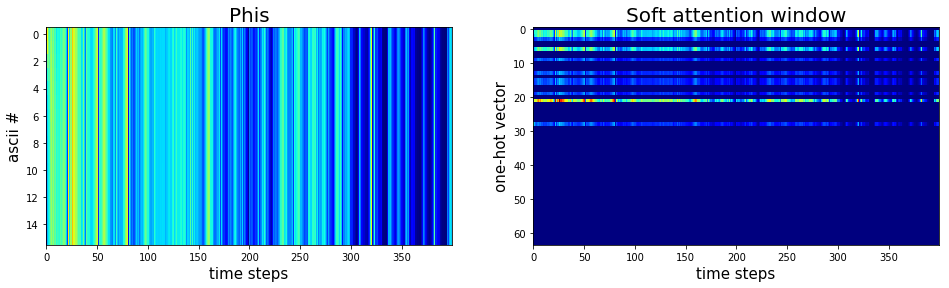

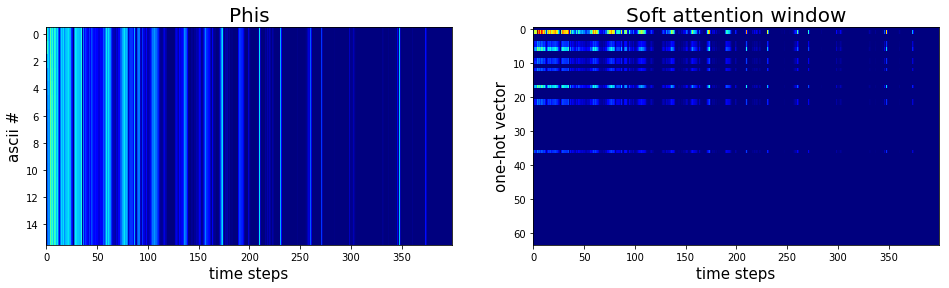

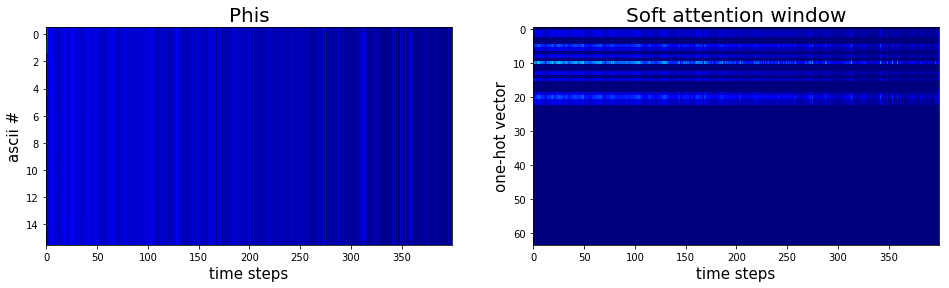

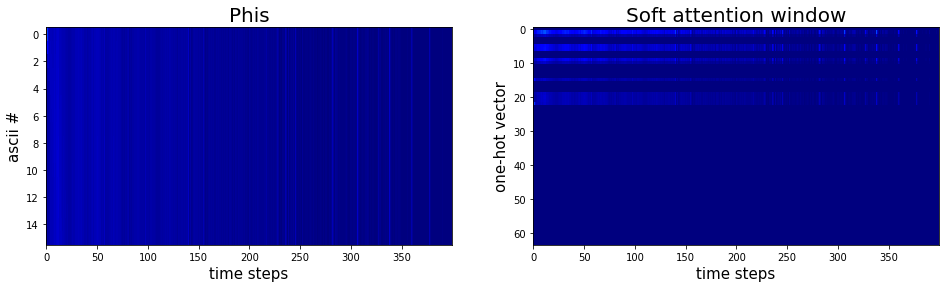

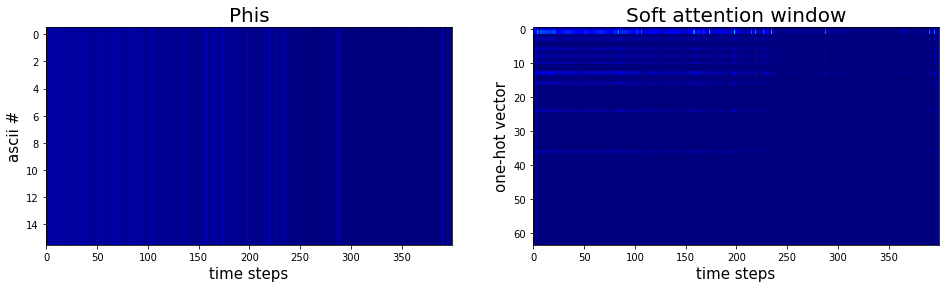

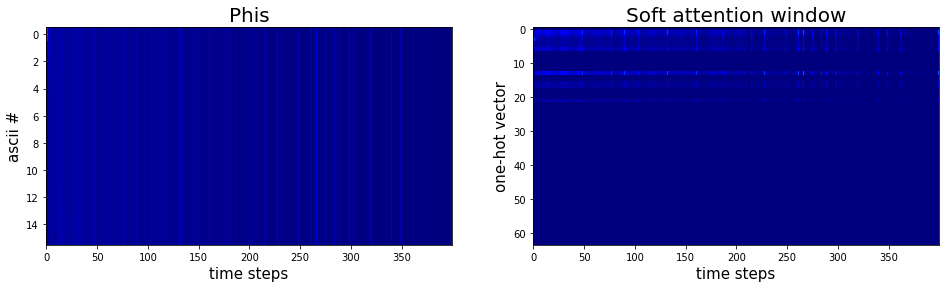

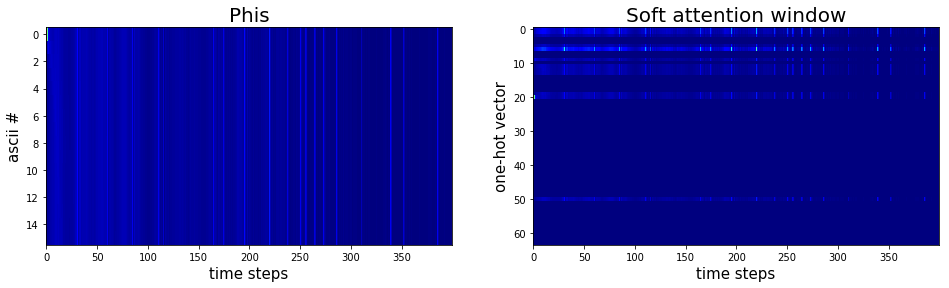

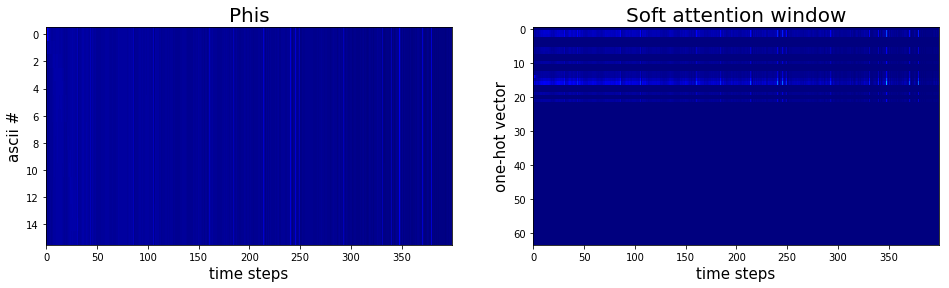

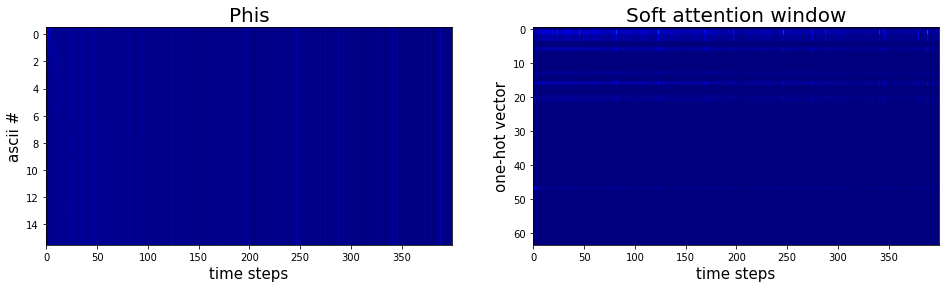

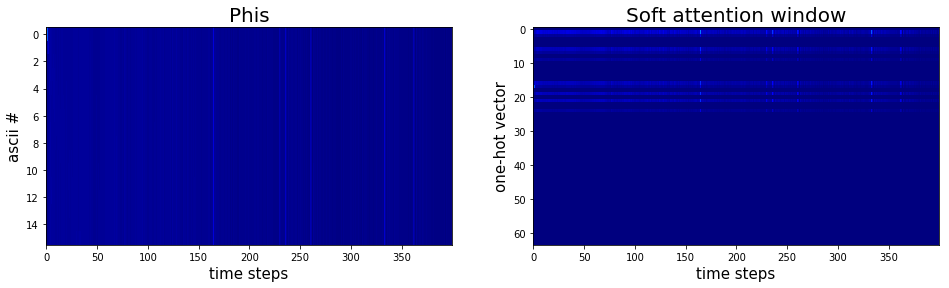

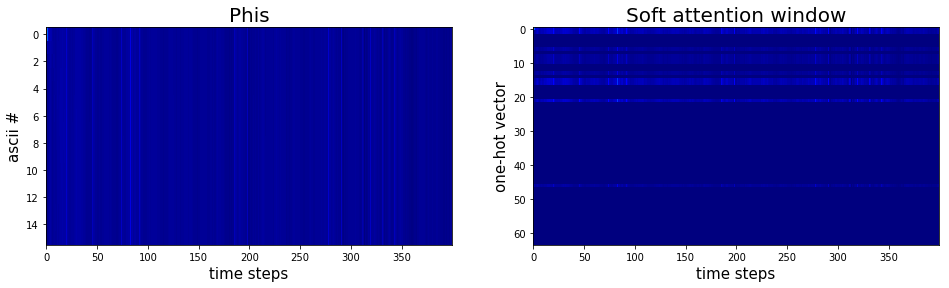

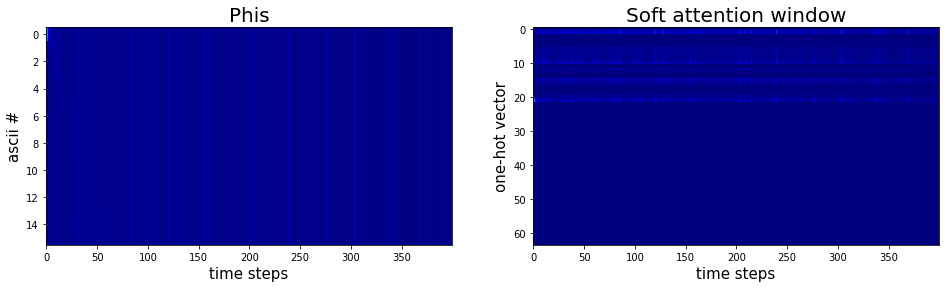

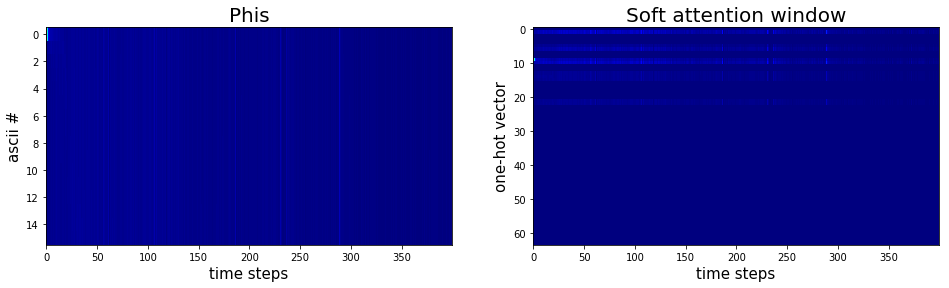

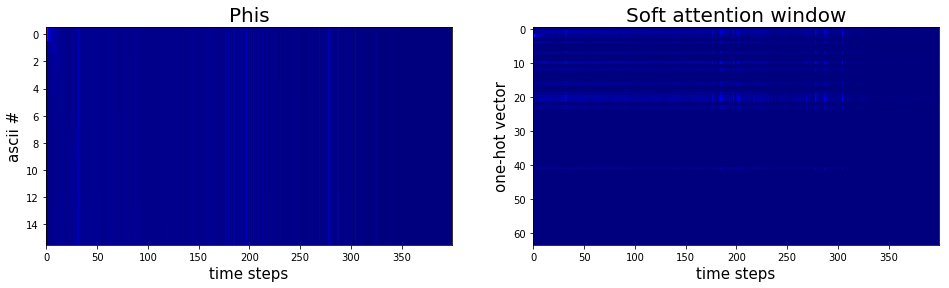

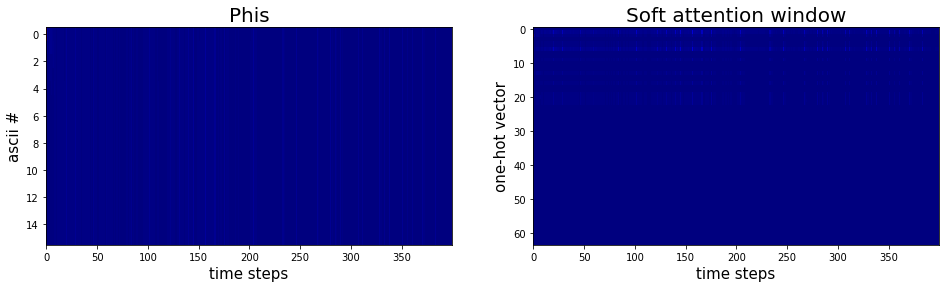

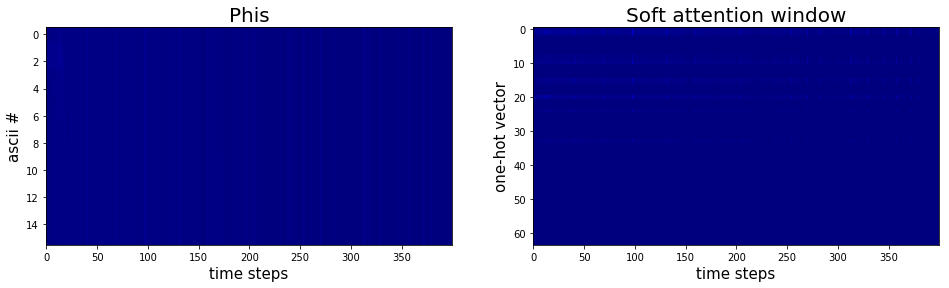

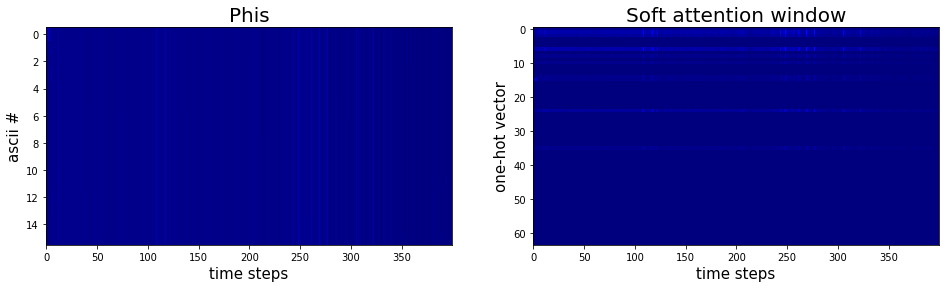

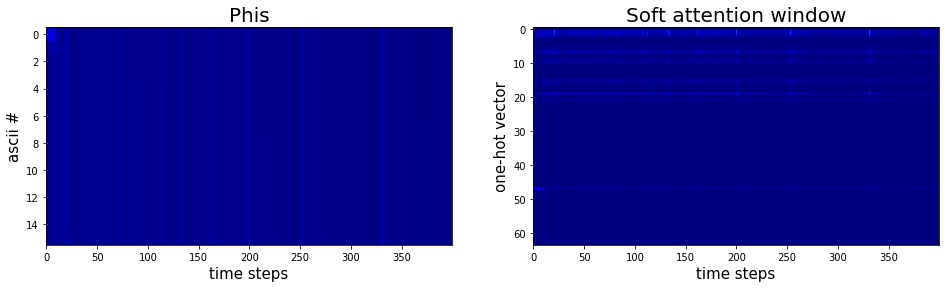

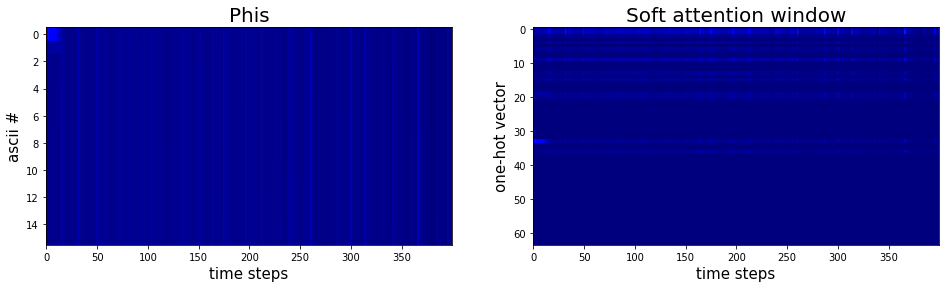

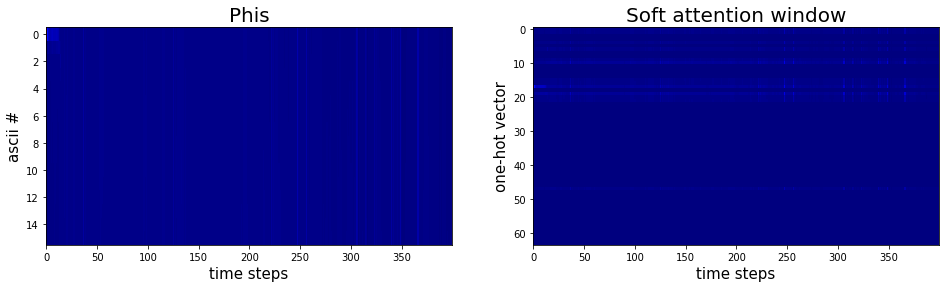

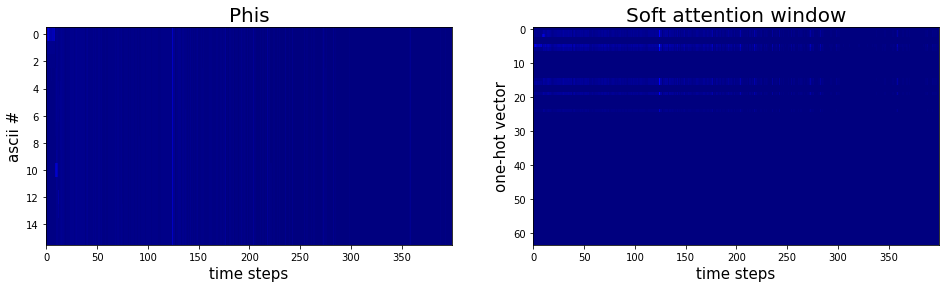

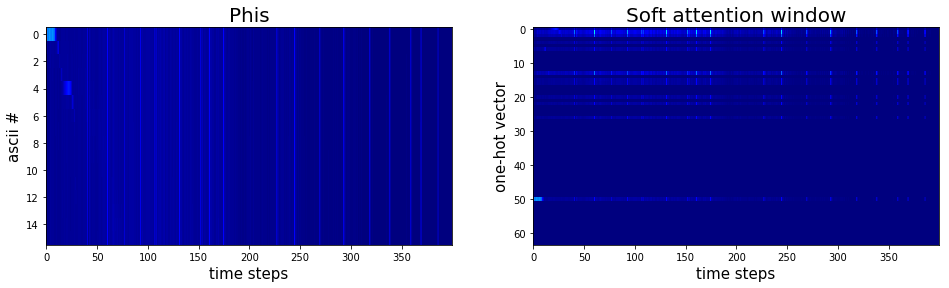

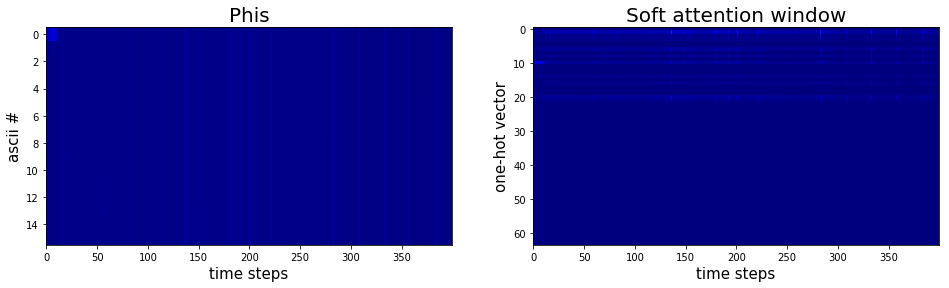

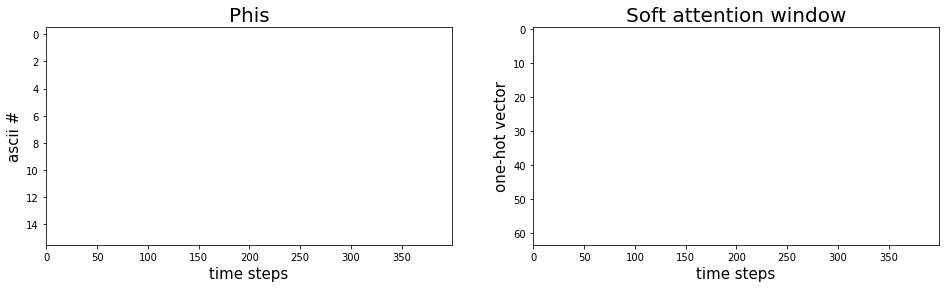

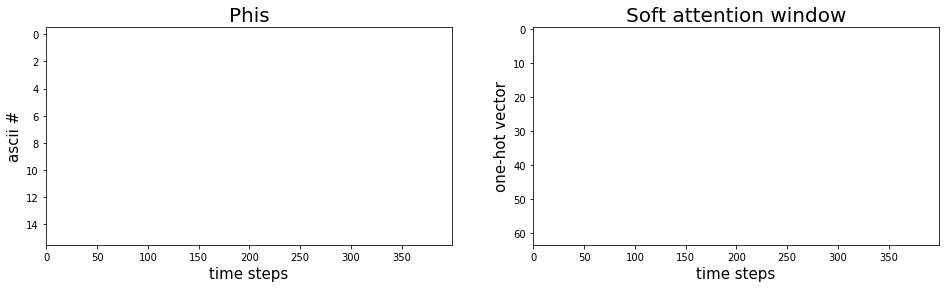

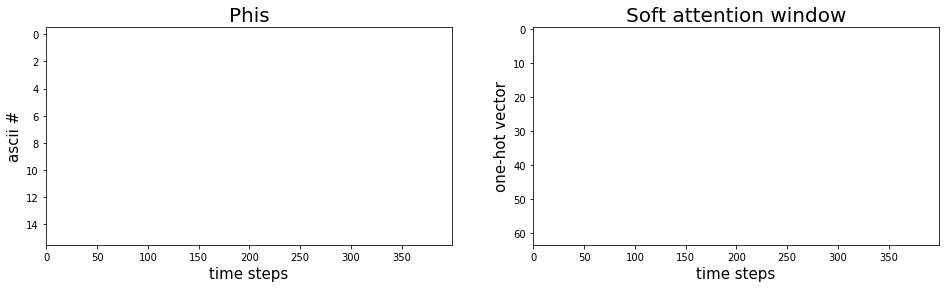

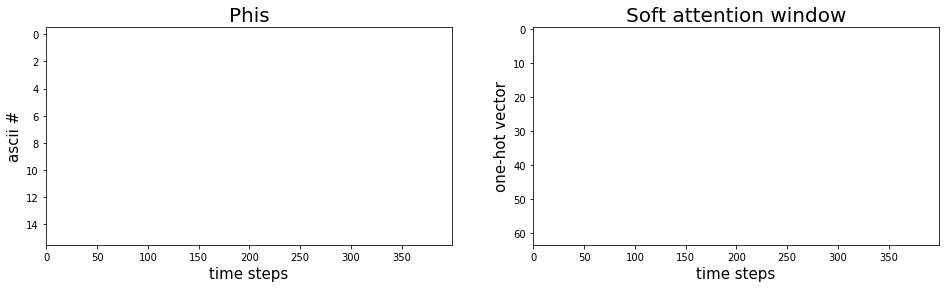

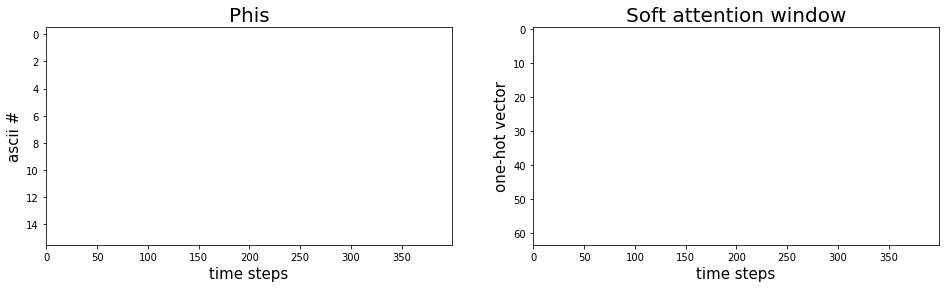

In [8]:
torch.cuda.empty_cache()
model = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

model = train_network(model, epochs = 50, generate = True)




## Test cell

```Python
torch.cuda.empty_cache()

modelTest = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
x, y, s, c = data_loader.next_batch()
x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
c = np.float32(np.array(c))

x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    modelTest = modelTest.cuda()
    x = x.cuda()
    y = y.cuda()
    c = c.cuda()

es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos, Phis, Ws = modelTest.forward(x, c)


Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
loss = loss_fn(Pr,y, es)

test = one_hot("Will it ever work ?")

x0 = torch.Tensor([0,0,1]).view(1,1,3)
c0 = np.float32(one_hot("Laurent estun PD"))
c0 = torch.from_numpy(c0) 
c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    x0 = x0.cuda()

sequence = model.generate_sequence(x0, c0)
print(sequence.shape)
draw_strokes_random_color(sequence, factor=0.5)
```